In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import os 
import numpy as np 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

import seaborn as sns
sns.set_style('white', {"xtick.major.size": 2, "ytick.major.size": 2})
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#f4cae4"]
sns.set_palette(sns.color_palette(flatui,7))
import matplotlib.pyplot as plt

In [2]:
base_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(base_dir, 'Dataset')
file_name = 'household_power_consumption.txt'

In [3]:
# Load data
energy_data = pd.read_csv(os.path.join(data_dir, file_name), sep=';', header=0,parse_dates={'DateTime' : ['Date','Time']}, infer_datetime_format=True, na_values=['nan','?'], index_col='DateTime')

In [4]:
energy_data.head()

Global_active_power  Global_reactive_power  Voltage  \
DateTime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
DateTime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00              15.8             0.0             1.0   

                     Sub_metering_3  
DateTime                             
2006-12-16 17:24:00            17.0  
2006-12-16 17:25:00            16.0  
2006-12-16 17:26:00            17.0  
2006-12-16 17:27:00            17.0  
2006-12-16 17:28:00            17.0

### Dataset Description

- **date**: Date in format dd/mm/yyyy
- **time**: time in format hh:mm:ss
- **global_active_power**: household global minute-averaged active power (in kilowatt)
- **global_reactive_power**: household global minute-averaged reactive power (in kilowatt)
- **voltage**: minute-averaged voltage (in volt)
- **global_intensity**: household global minute-averaged current intensity (in ampere)
- **sub_metering_1**: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
- **sub_metering_2**: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
- **sub_metering_3**: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

In [5]:
print("Total Number of Rows :", energy_data.shape[0])

Total Number of Rows : 2075259


In [6]:
# Check for null values 
energy_data.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

**Analysis**
- There are around 25k null values for each feature.
- We can impute these values either by previous week/month/year mean, median. Lets first visualize the data to observe the trends

In [41]:
#energy_data.plot(subplots=True, figsize=(20,8))

**Analysis**

- **Global Active Power**
The global active power consumption shows clear seasonal patterns with peaks typically occurring at regular intervals. This suggests a cyclical behavior in power usage, which could be related to seasonal changes in weather, leading to more heating or cooling requirements. There might also be underlying trends, such as a gradual increase or decrease in power consumption over the years, but this is not immediately apparent from the plot and would require further analysis, such as calculating a moving average or applying a trend decomposition method.

- **Global Reactive Power**
The global reactive power also exhibits seasonal fluctuations similar to the active power, indicating that the consumption of both active and reactive power is influenced by similar factors. The reactive power does not show a clear long-term trend in the plot, but it does have regular peaks and troughs, which suggests that devices that use reactive power are also used seasonally.

- **Voltage**
The voltage plot shows minor fluctuations around what appears to be a relatively stable mean value. There is no clear seasonality or trend in the voltage data, which is expected as voltage levels in power systems are typically regulated to remain within a specific range for safety and equipment compatibility reasons.

- **Global Intensity**
Global intensity, which is related to the average current draw, shows variability that mirrors the patterns seen in the global active power plot. This suggests that as more power is consumed, the intensity or current draw also increases. The seasonality is evident, with similar peaks and troughs, but a long-term trend is not immediately visible.

- **Sub Metering 1**
Sub_metering_1 shows a lot of variability with numerous spikes, which could indicate the operation of specific appliances or systems that are turned on and off intermittently. There is no clear seasonality or trend from the plot, suggesting that the usage of whatever is being measured by this sub-metering is not strongly seasonally dependent or does not have a clear long-term trend.

- **Sub Metering 2**
Sub_metering_2 also displays a high level of granularity with many spikes, similar to sub_metering_1. This could be indicative of appliances or systems that are used sporadically. The appliances like washing machines are not used frequently, thats why shoes such granularity. The lack of a clear seasonal pattern or trend suggests that the usage is not tied to seasonal changes or does not follow a long-term trend.

- **Sub Metering 3**
Sub_metering_3 shows periods of sustained high or low values, which could indicate longer-term changes in usage patterns, such as the addition or removal of electrical devices or changes in occupancy patterns. There are also spikes that could correspond to intermittent use of high-power devices. The seasonality is not as clear as in the global active power, and any trends would need to be analyzed with additional statistical methods. In 2007, the AC usage are mostly constant. In 2008 and 2009, there is high usage during certain months, this may be due to extreme summers. While from 2010, there is high usage throughout.


#### Yearwise Visualization

- For imputing values, lets analyse the data for individual years, to get a clear idea of what kind of imputations can be done
- Analyse the trends (if any within a year)

In [7]:
def feature_visualize_yearly(data, feat_name):
    """Method to visualize the time series data for a given feature on yearly level"""
    
    fig, axis = plt.subplots(4, 1, figsize=(30,8))
    
    for i, d in enumerate(zip(axis, list(data[feat_name].groupby(data.index.year))[1:])):
        d[0].plot(pd.DataFrame(d[1][1]), label=d[1][0])
        d[0].legend(loc='upper right', fontsize='12', frameon=True).get_frame().set_edgecolor('blue') 
    
    fig.text(0.40, 0.9, 'Year-Wise Analysis : %s ' %feat_name, va='center',  fontdict={'fontsize': 25})
    plt.show()  

#### Analysis of Global Active Power

- Yearly there is a increasing trend from September to December
- Yearly there is a decreasing trend from July to September
- Missing values can be found in year 2007, 2009 and 2010

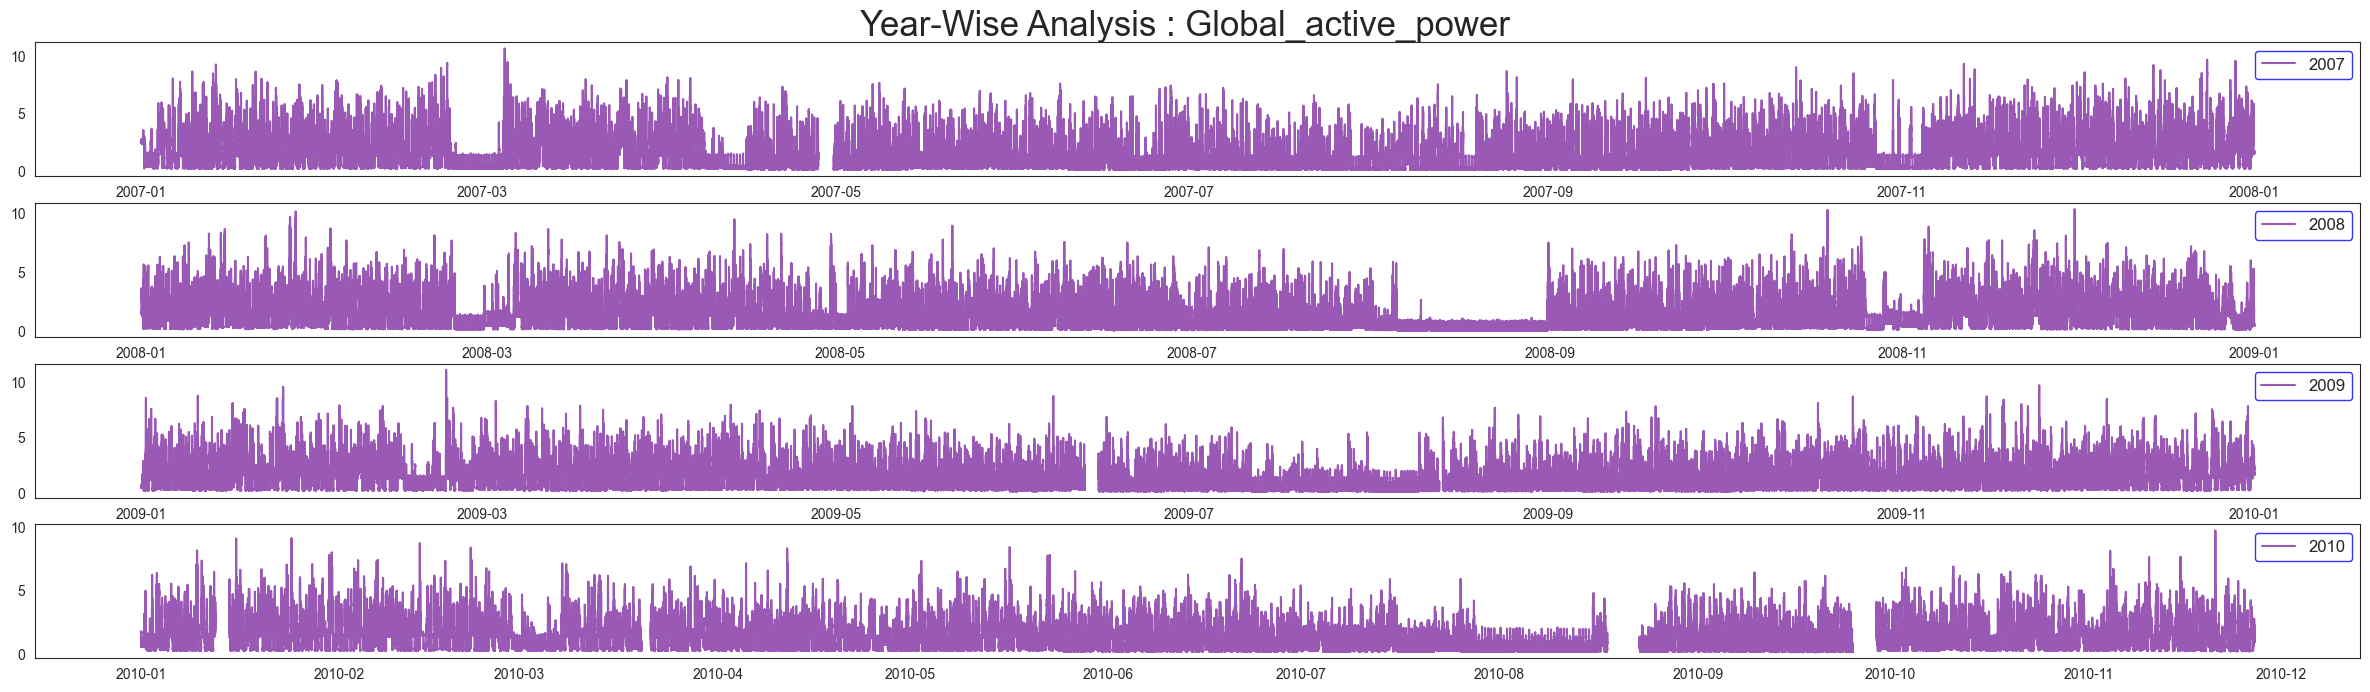

In [8]:
feature_visualize_yearly(data=energy_data, feat_name='Global_active_power')

#### Analysis of Global Reactive Power

- There is no clear long-term trend (upward or downward) that is consistent across all years. Instead, the global reactive power seems to fluctuate within a certain range without a clear increase or decrease over the years.
- The reactive power does not show any conspicuous spikes that would indicate a sudden increase in consumption, which might occur due to the use of heavy electrical equipment.
- There are missing values for year 2007, 2009 and 2010


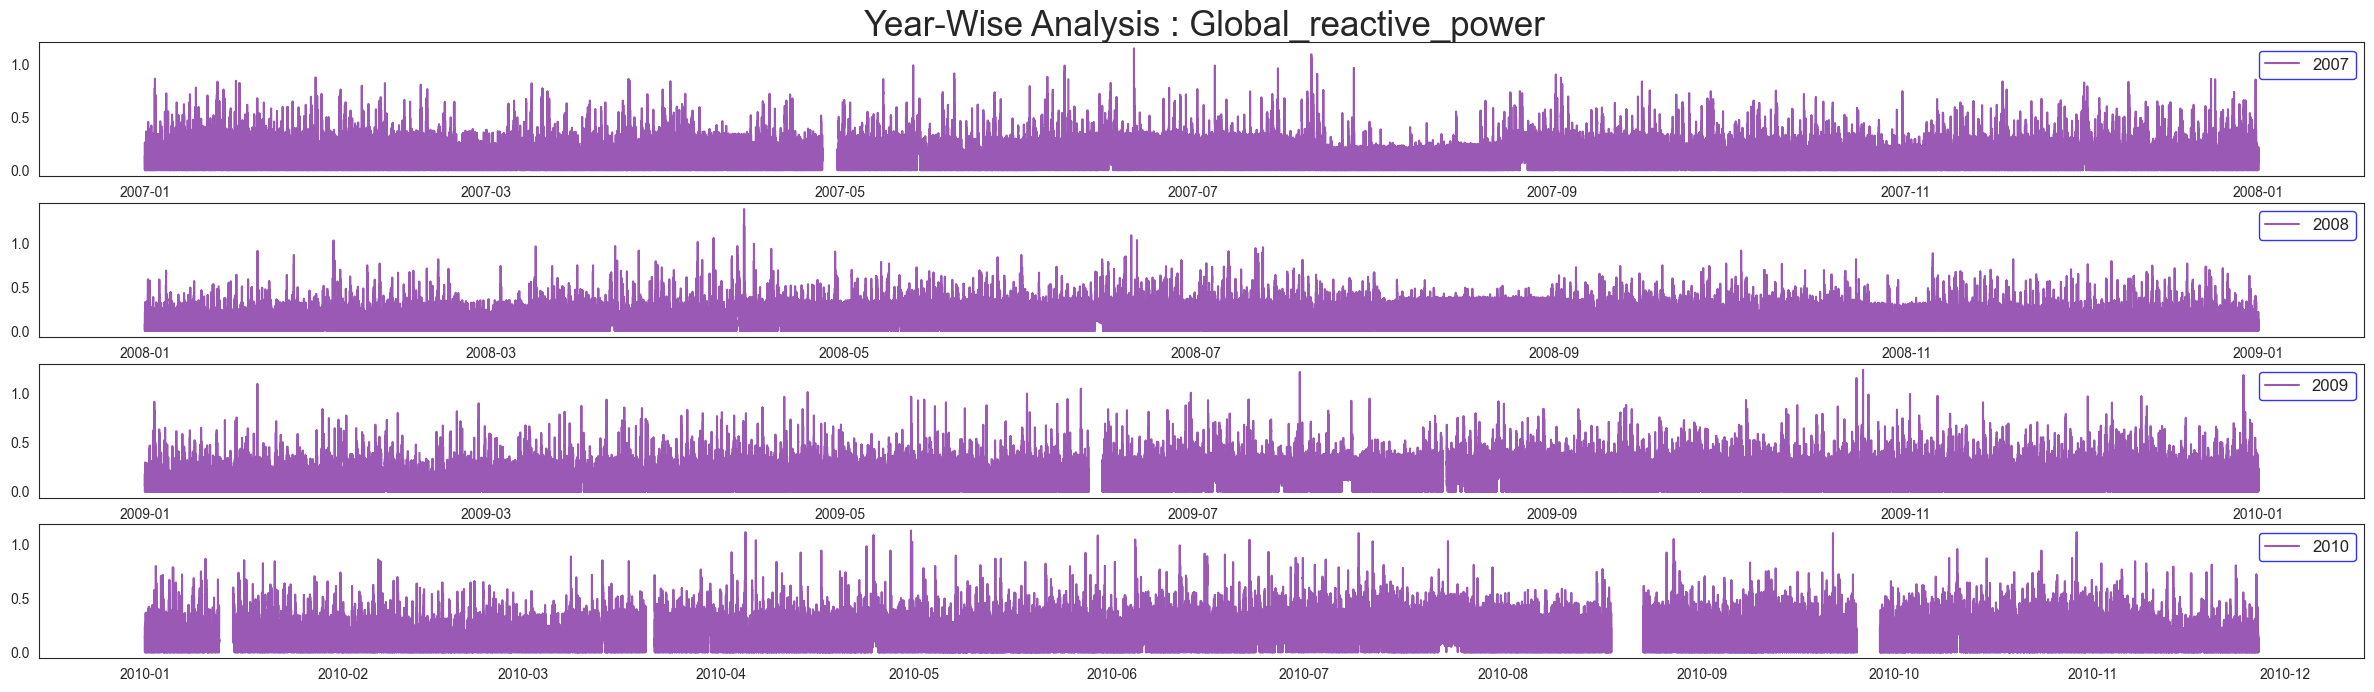

In [9]:
feature_visualize_yearly(data=energy_data, feat_name='Global_reactive_power')

#### Analysis of Voltage

- Stability: Voltage levels should be relatively stable with small fluctuations. This graph shows that overall, the voltage remains within a narrow band, suggesting a stable power supply and consistent voltage regulation.
- Annual Comparison: Comparing each year, the voltage level seems consistent from 2007 to 2010 without any significant long-term upward or downward trends.
- Missing Values : There are missing values in year 2007 and 2010

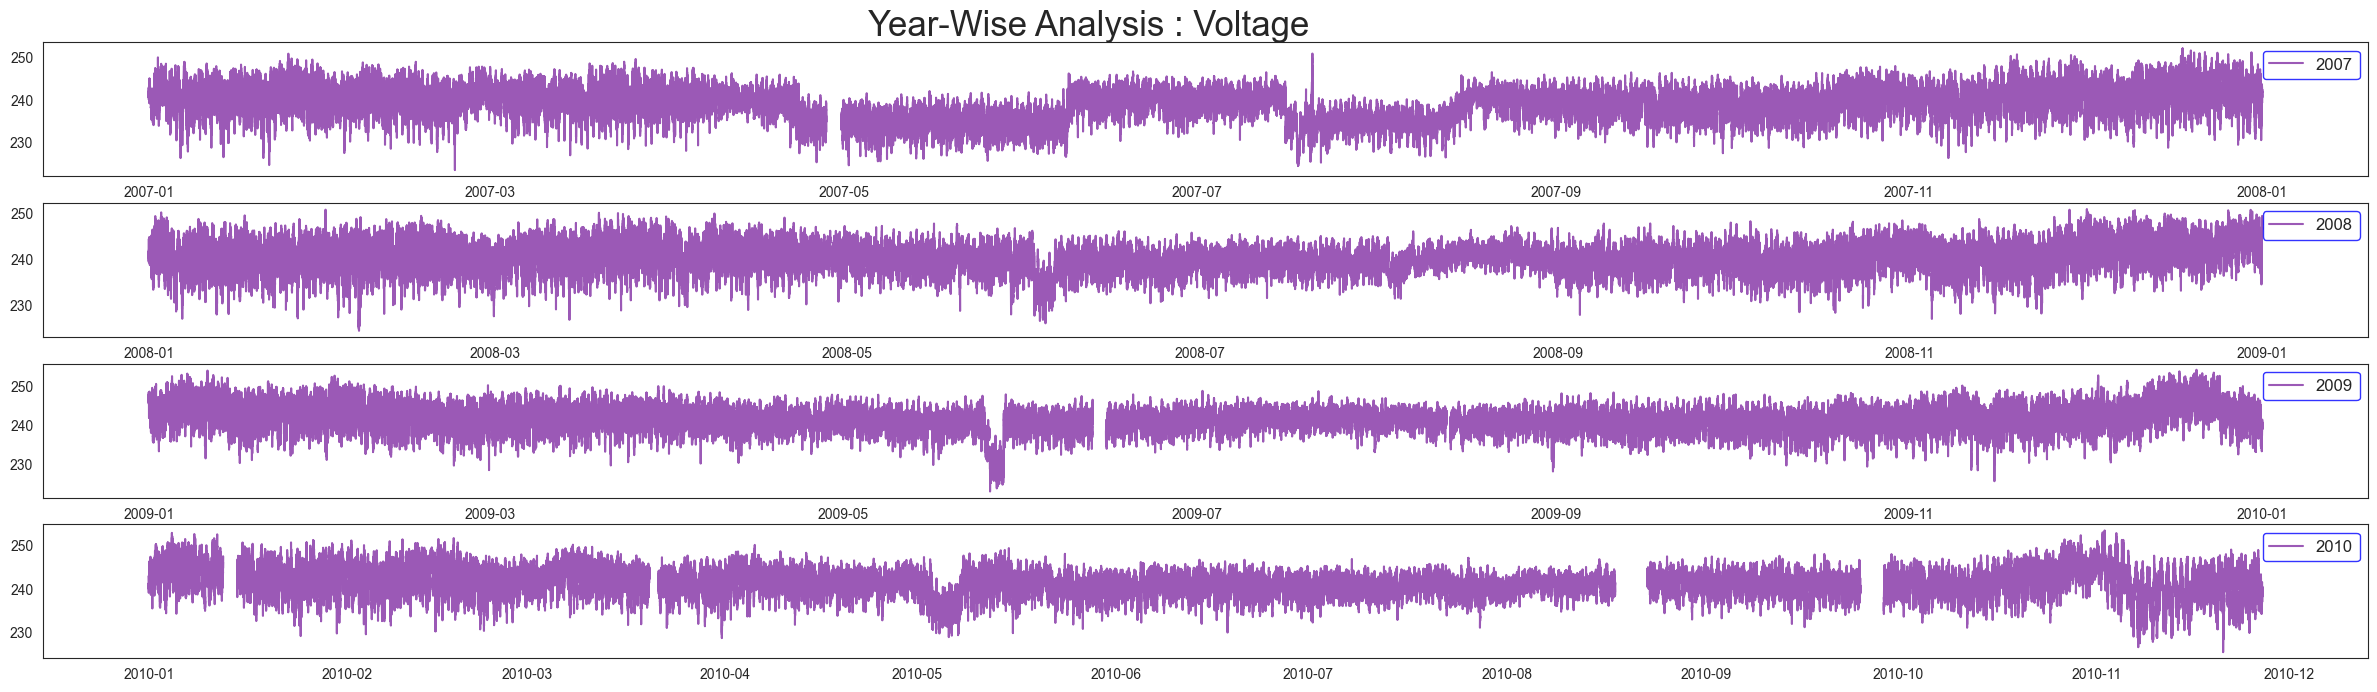

In [10]:
feature_visualize_yearly(data=energy_data, feat_name='Voltage')

#### Analysis of Global Intensity

- **Seasonality**: There seems to be a repeating pattern within each year, where intensity peaks at certain times and dips at others. This could indicate higher energy usage in winter and summer, possibly due to heating and air conditioning needs, which are common seasonal loads.

- **Trends**: There is increasing trend from Sept to December every year while decreasing trend form August to Sept

- **Variability**: There is noticeable variability within the data, with short-term spikes in intensity. These could correlate with daily activities, such as cooking, laundry, or other high-energy tasks.

- **Missing Values** : Missing values found in year 2009 and 2010

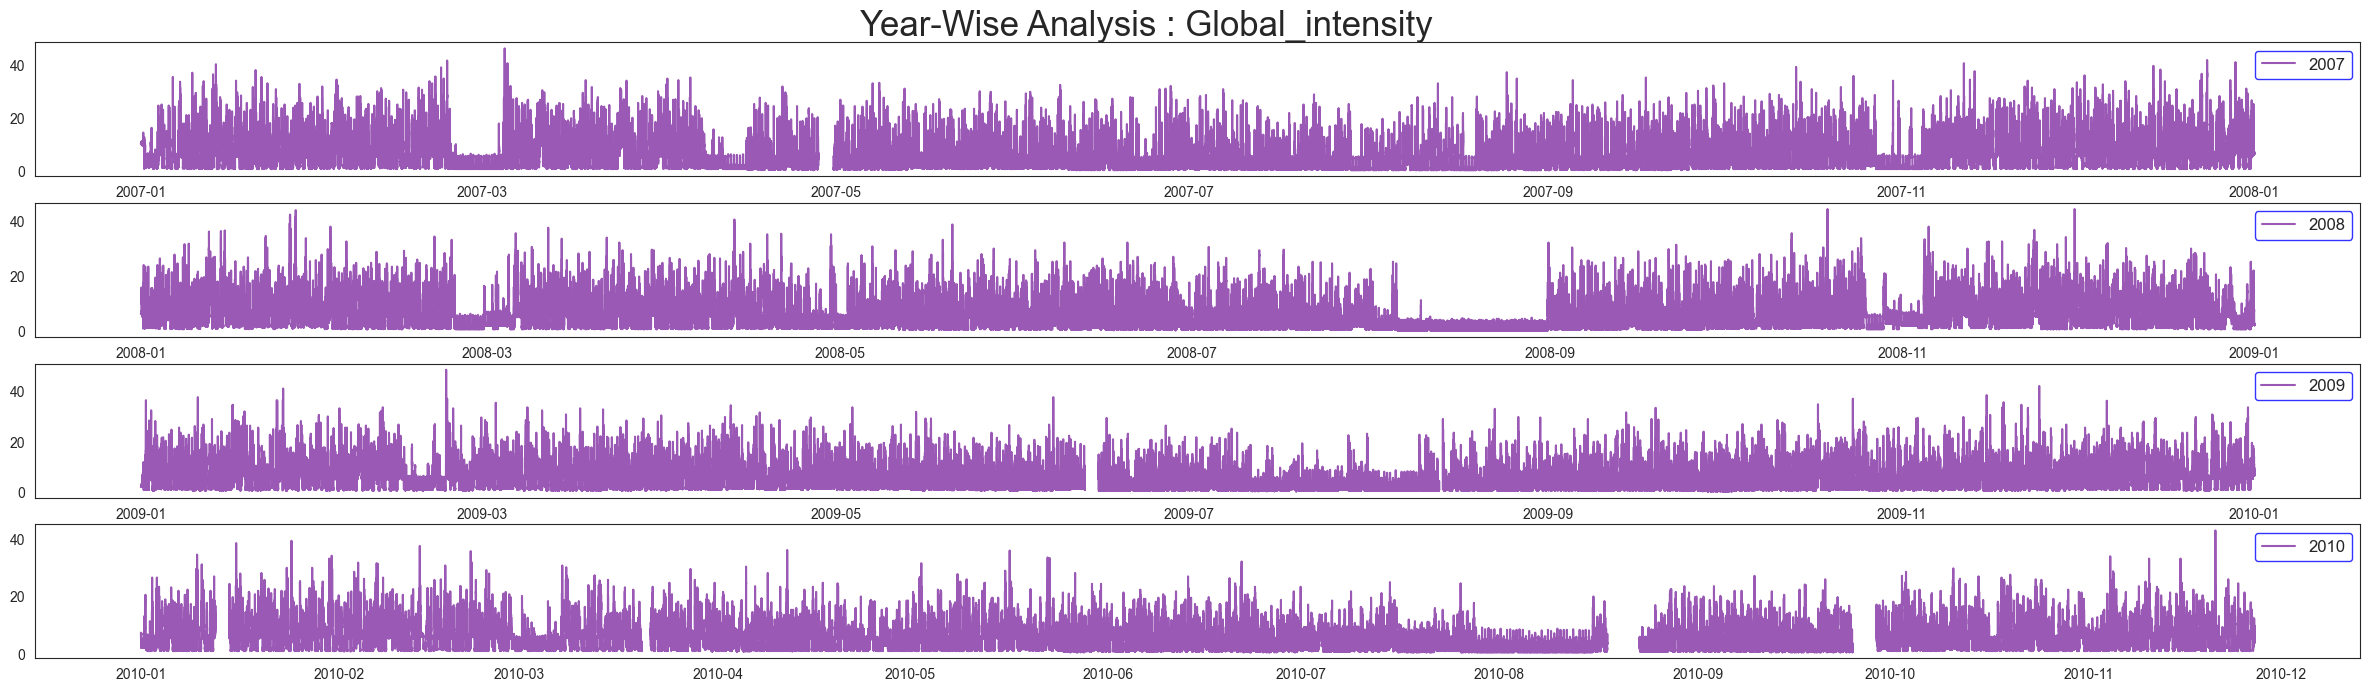

In [11]:
feature_visualize_yearly(data=energy_data, feat_name='Global_intensity')

#### Analysis of Sub Metering 1

- No yearly trend is there. There are certainly spikes in data which may be due to on and off the devices or some occasions.
- Miising values in 2010

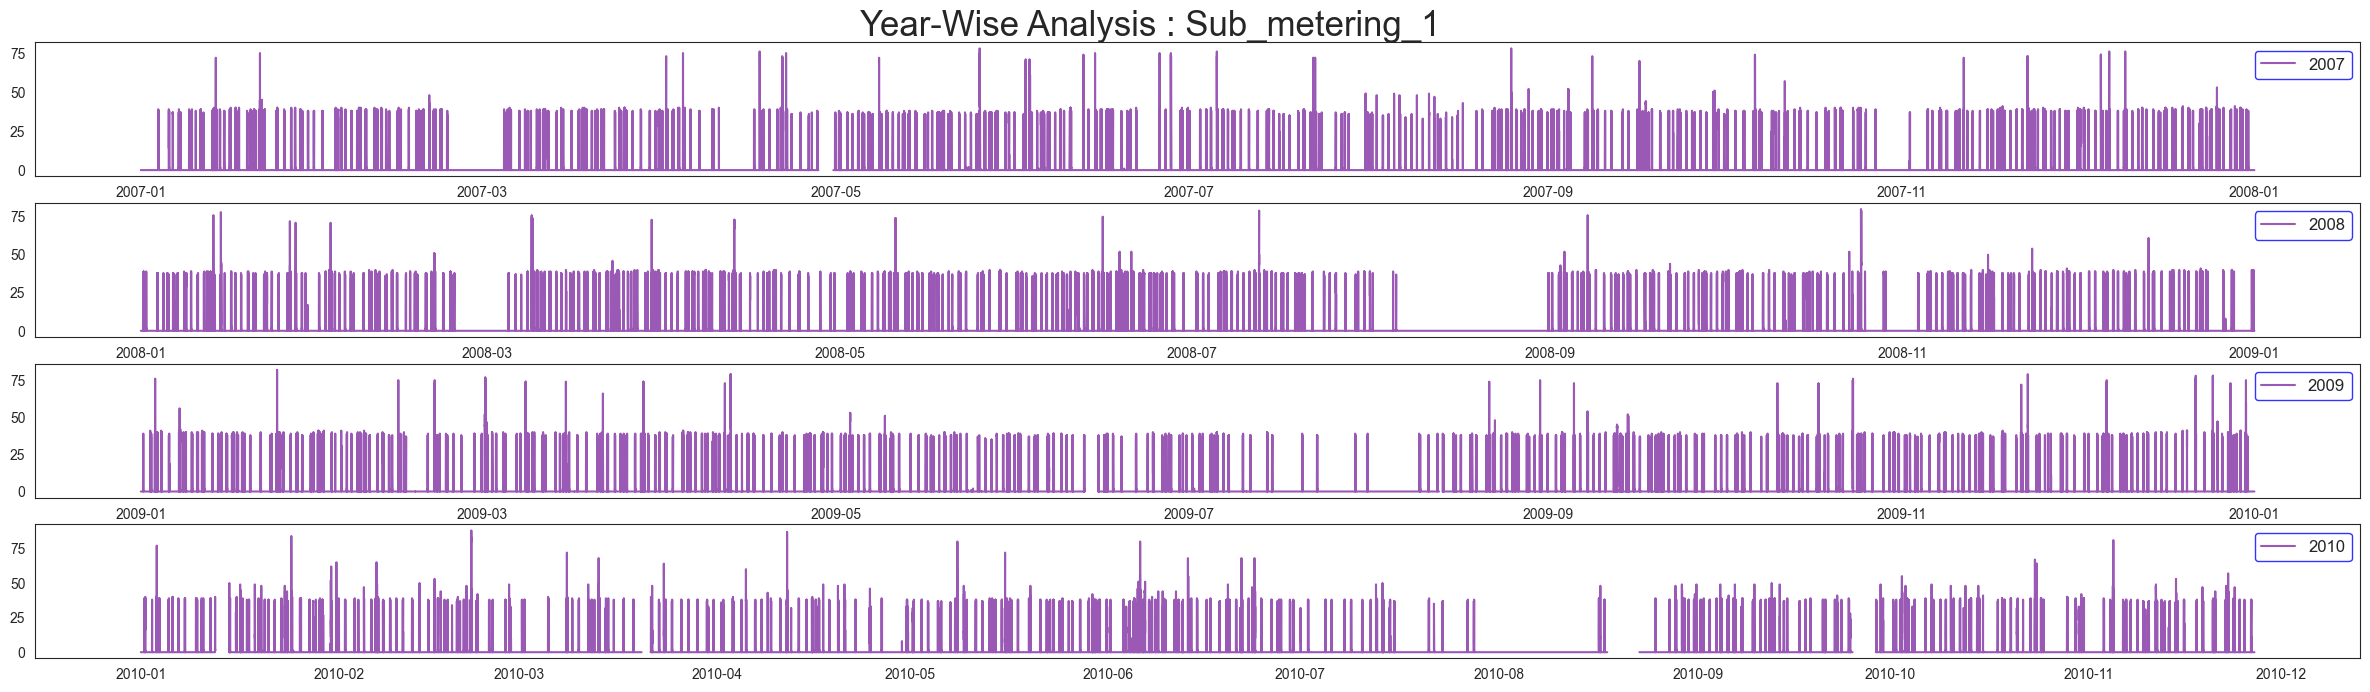

In [12]:
feature_visualize_yearly(data=energy_data, feat_name='Sub_metering_1')

#### Analysis of Sub Metering 2

- Missing Values are found in year 2010

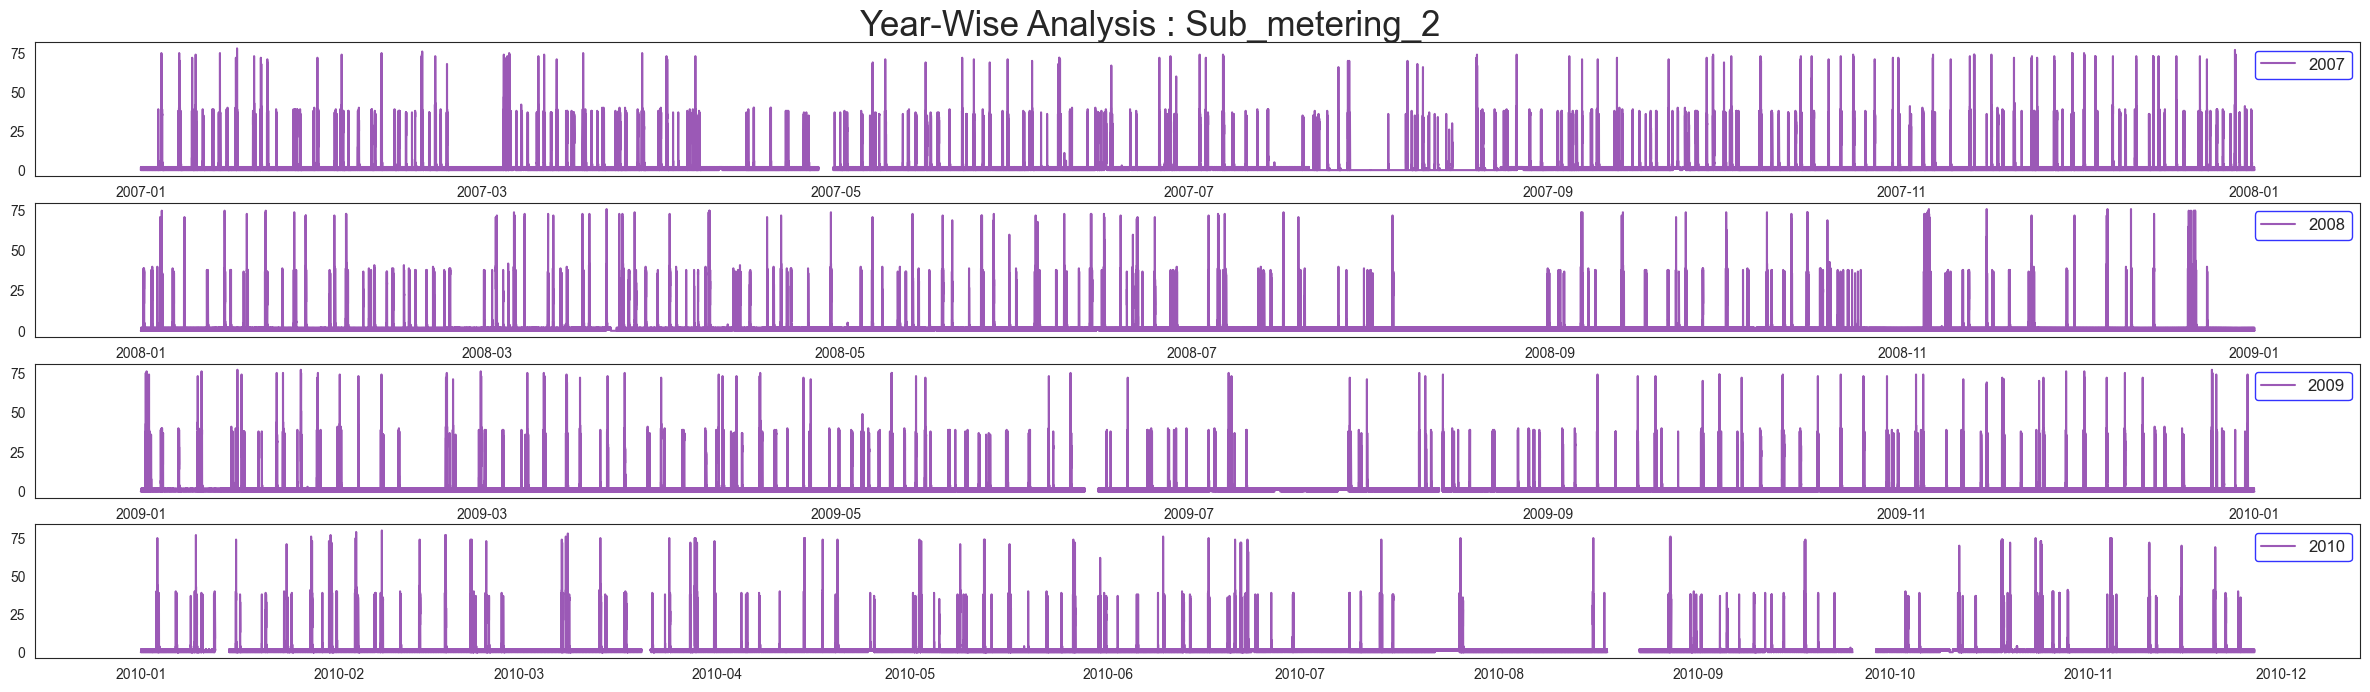

In [13]:
feature_visualize_yearly(data=energy_data, feat_name='Sub_metering_2')

#### Analysis of Sub Metering 3

- Missing values are found in 2007, 2009 and 2010

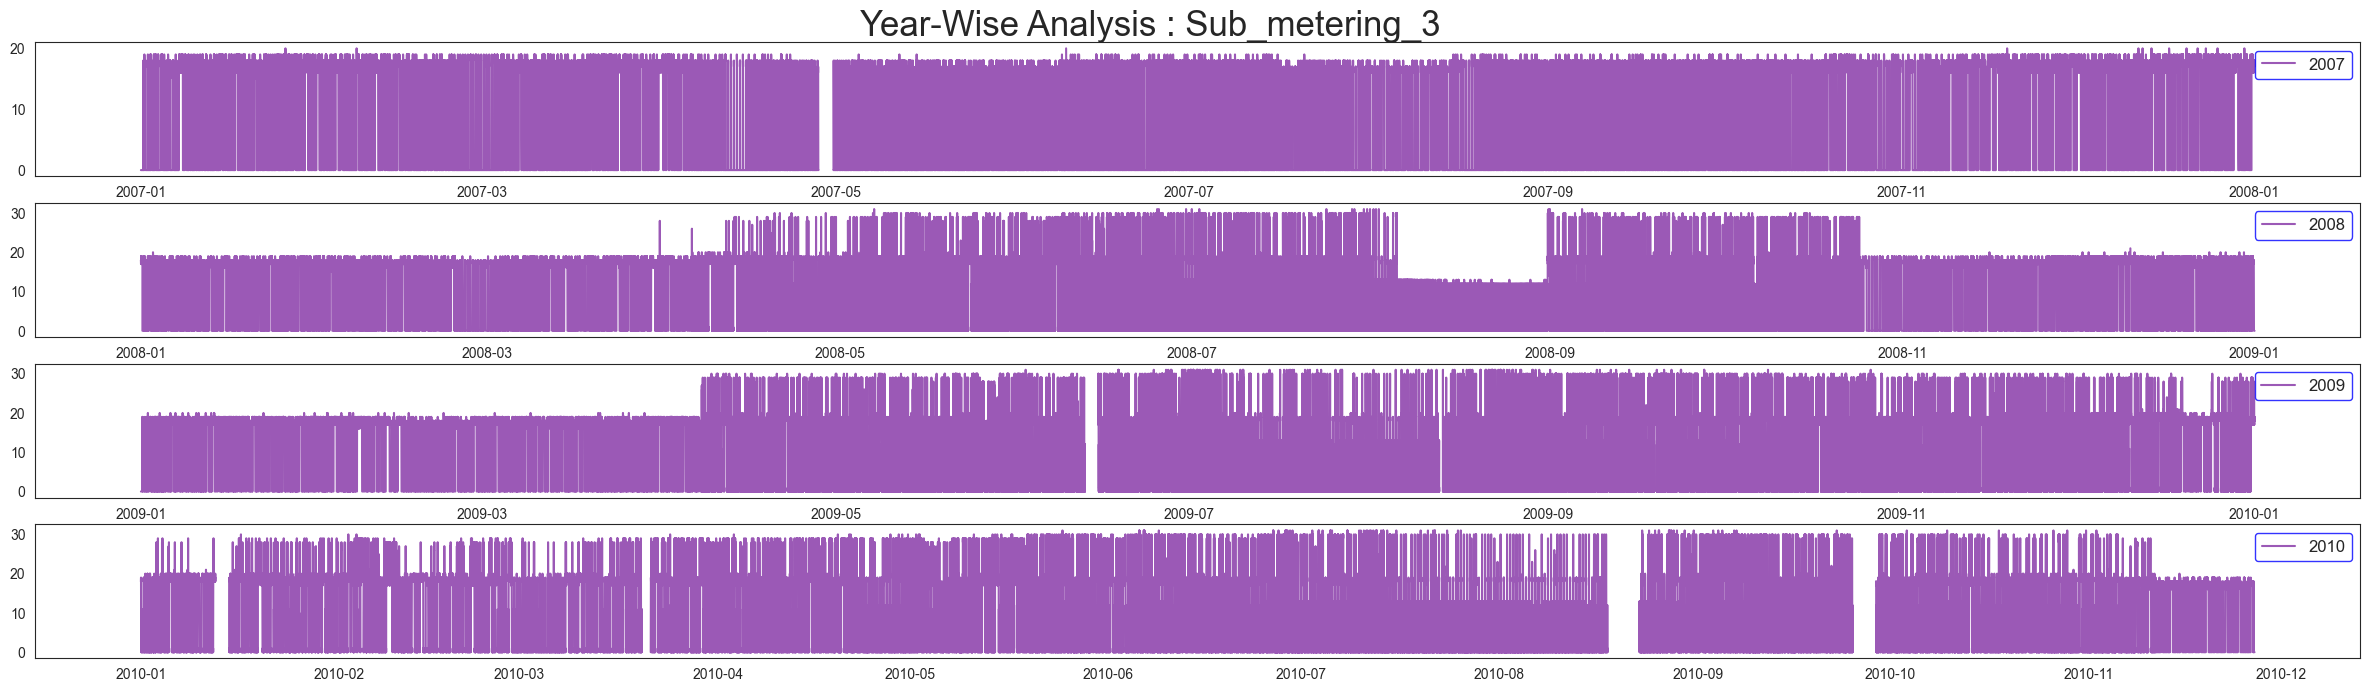

In [14]:
feature_visualize_yearly(data=energy_data, feat_name='Sub_metering_3')

**Conclusion on Missing Data**

Since there is not much variability in the yearly data. We can replace yearly missing values with yearly mean

In [15]:
def impute_missing_values(df):
    """Imputte null values in the dataframe with yearly mean"""
    final_data = []
    for year, df_grp in df.groupby(df.index.year):
        tmp_data = df_grp.fillna(df_grp.mean())
        final_data.append(tmp_data)

    return pd.DataFrame(data=np.vstack(final_data), columns=df.columns, index = df.index)

In [16]:
energy_data = impute_missing_values(df=energy_data)

In [17]:
# Check null values again
print(energy_data.shape)

energy_data.isnull().sum()

(2075259, 7)


Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

## Data Decomposition

In [18]:
def decompose_time_series(df, column_name):
    # Perform seasonal decomposition
    decomposition = seasonal_decompose(df[column_name], model='additive', period=1)
    
    # Plot the decomposed components
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 8))
    
    # Plot the original time series
    ax1.plot(df[column_name], label='Original')
    ax1.legend(loc='best')
    ax1.set_title('Original Time Series')
    
    # Plot the trend component
    ax2.plot(decomposition.trend, label='Trend')
    ax2.legend(loc='best')
    ax2.set_title('Trend Component')
    
    # Plot the seasonal component
    ax3.plot(decomposition.seasonal, label='Seasonal')
    ax3.legend(loc='best')
    ax3.set_title('Seasonal Component')
    
    # Plot the residual component
    ax4.plot(decomposition.resid, label='Residual')
    ax4.legend(loc='best')
    ax4.set_title('Residual Component')
    # Adjust layout
    plt.tight_layout()
    plt.show()

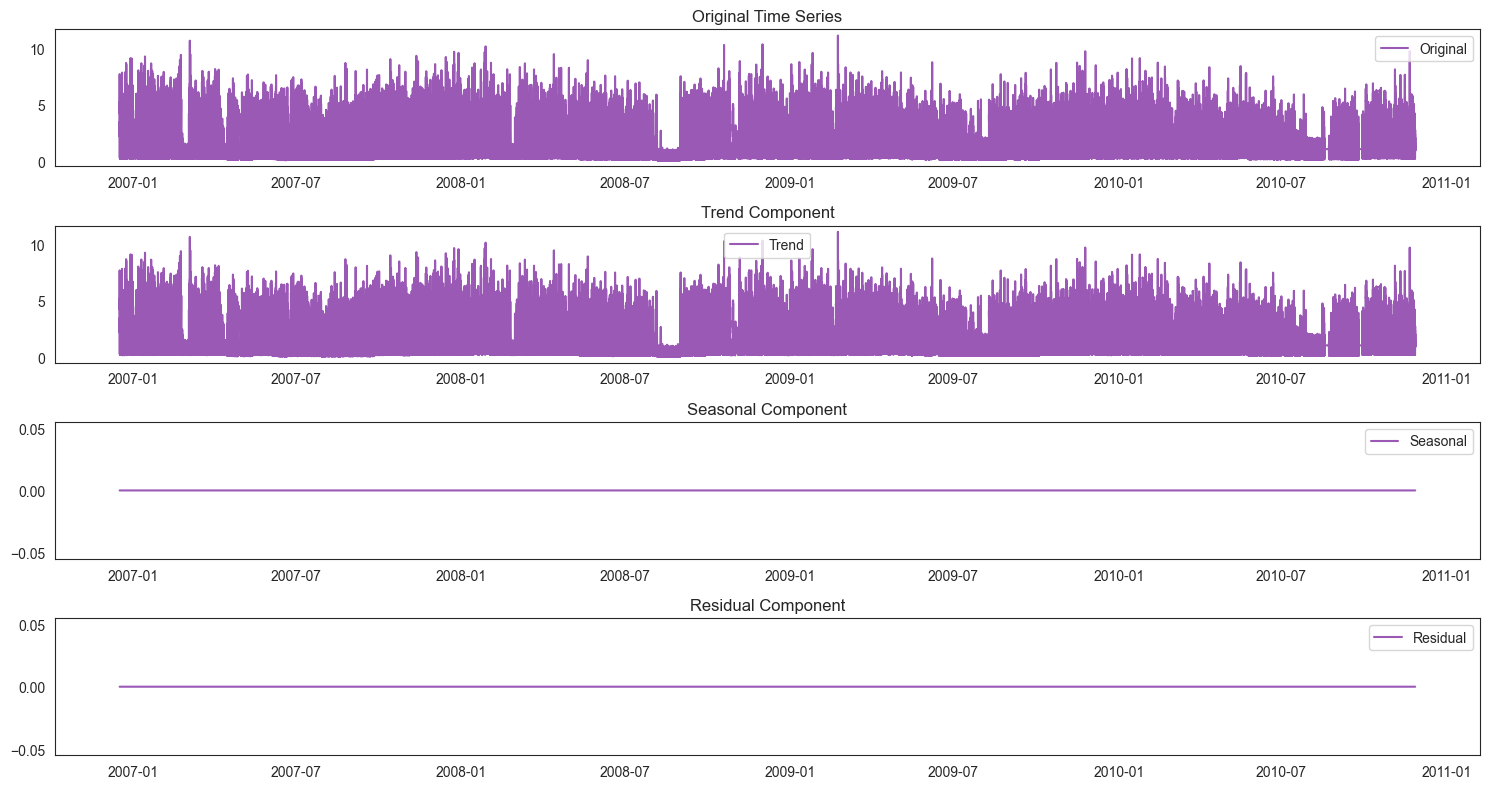

In [19]:
decompose_time_series(df=energy_data, column_name='Global_active_power')

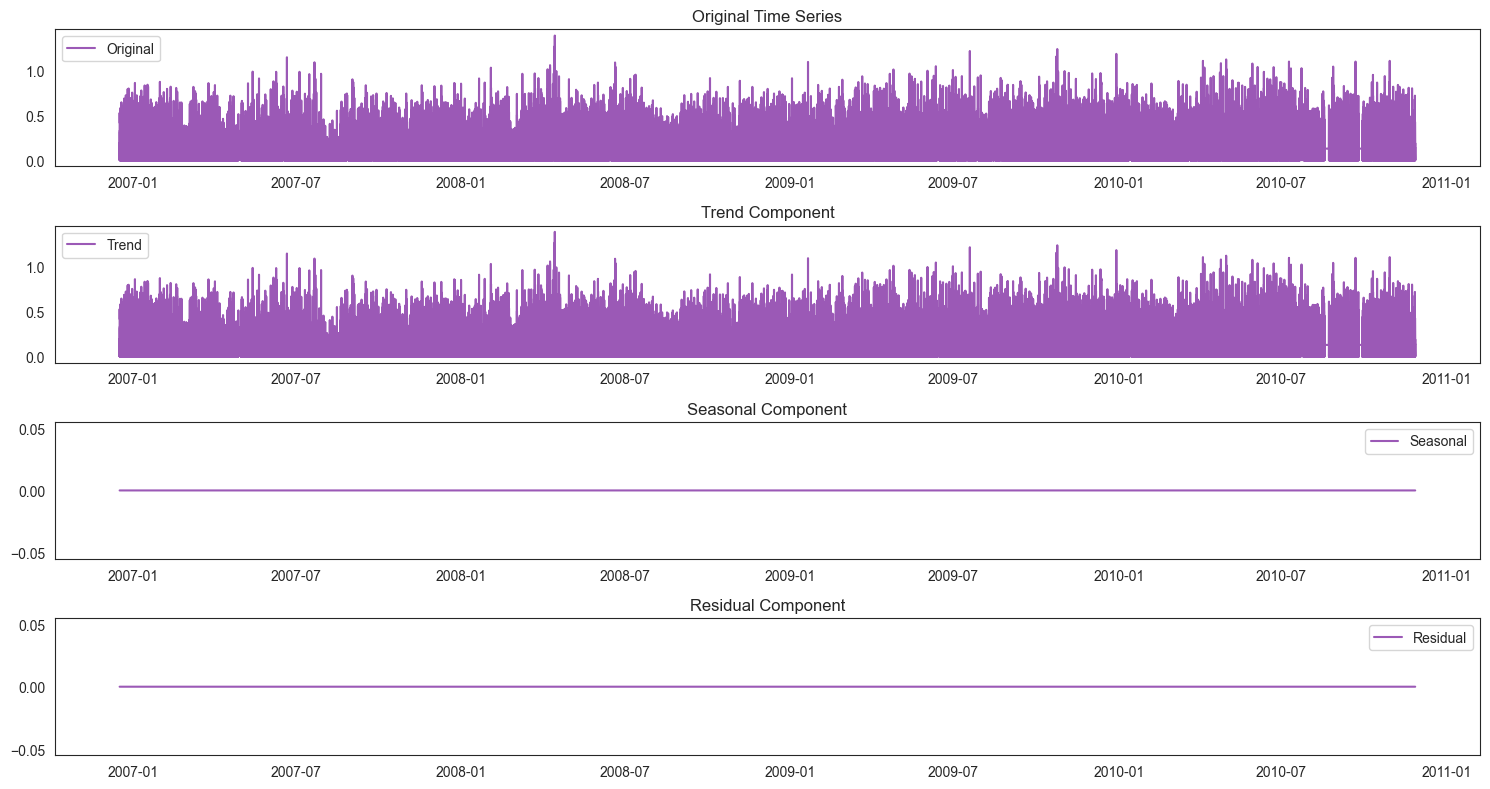

In [20]:
decompose_time_series(df=energy_data, column_name='Global_reactive_power')

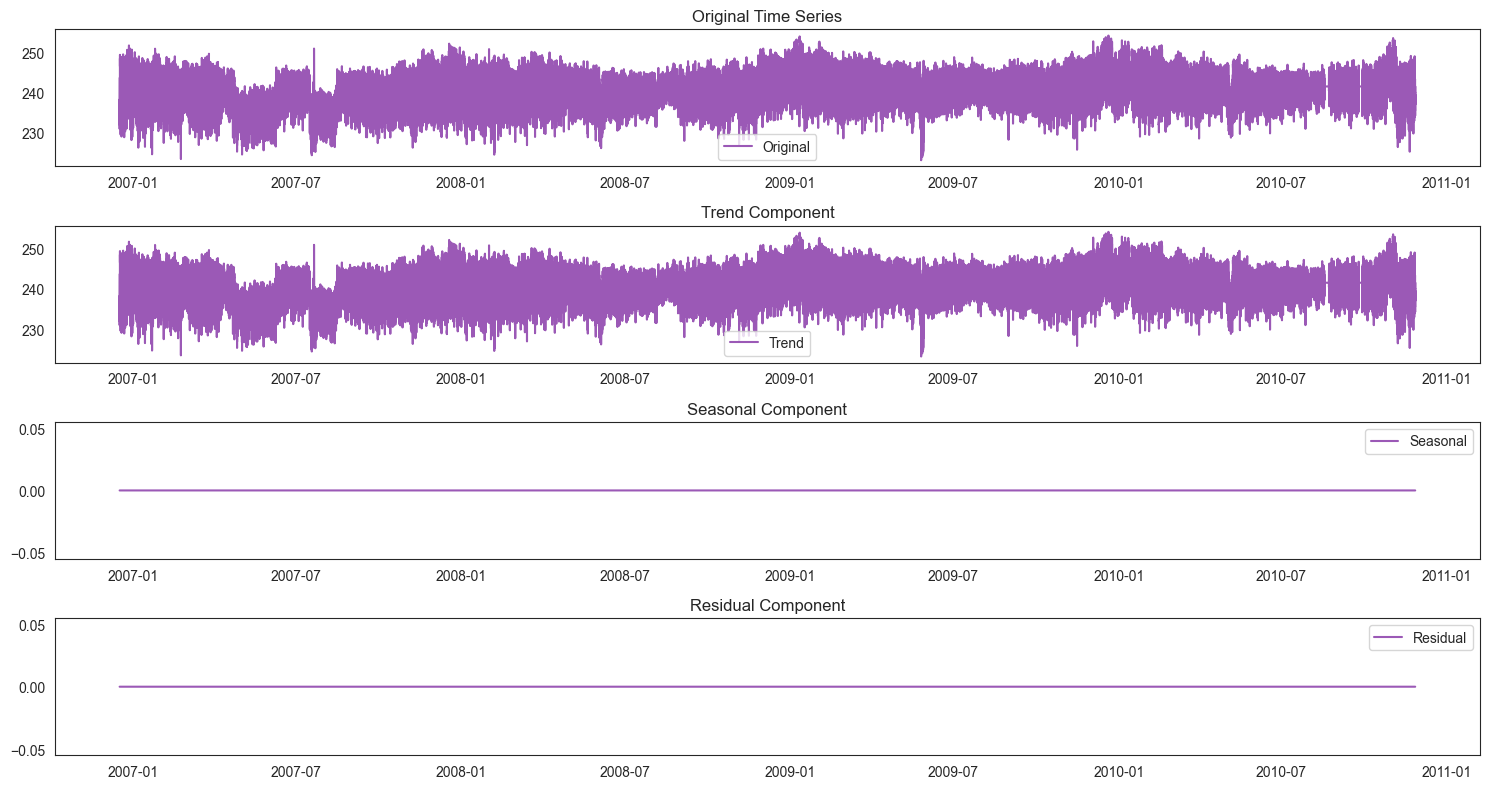

In [21]:
decompose_time_series(df=energy_data, column_name='Voltage')

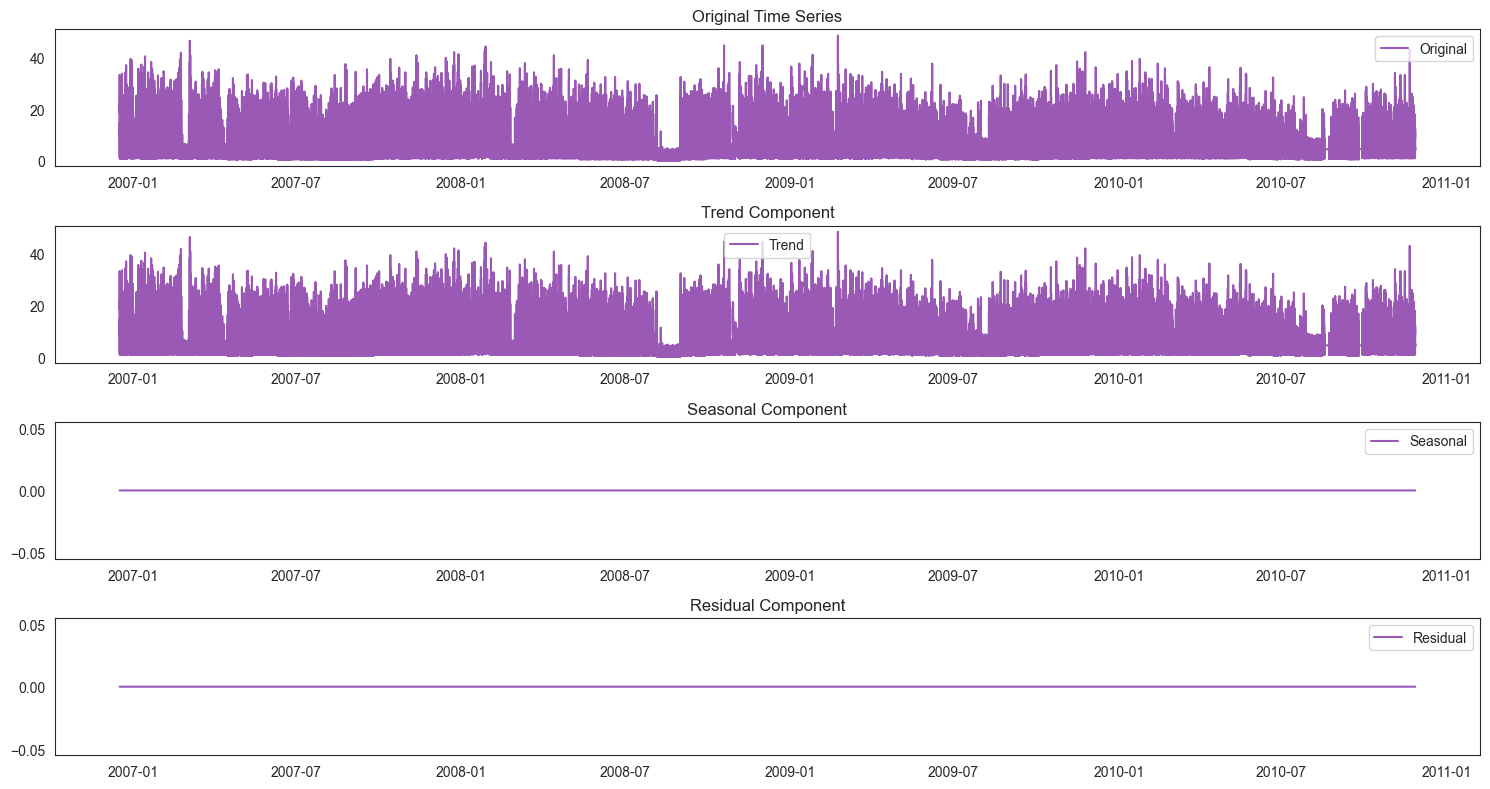

In [22]:
decompose_time_series(df=energy_data, column_name='Global_intensity')

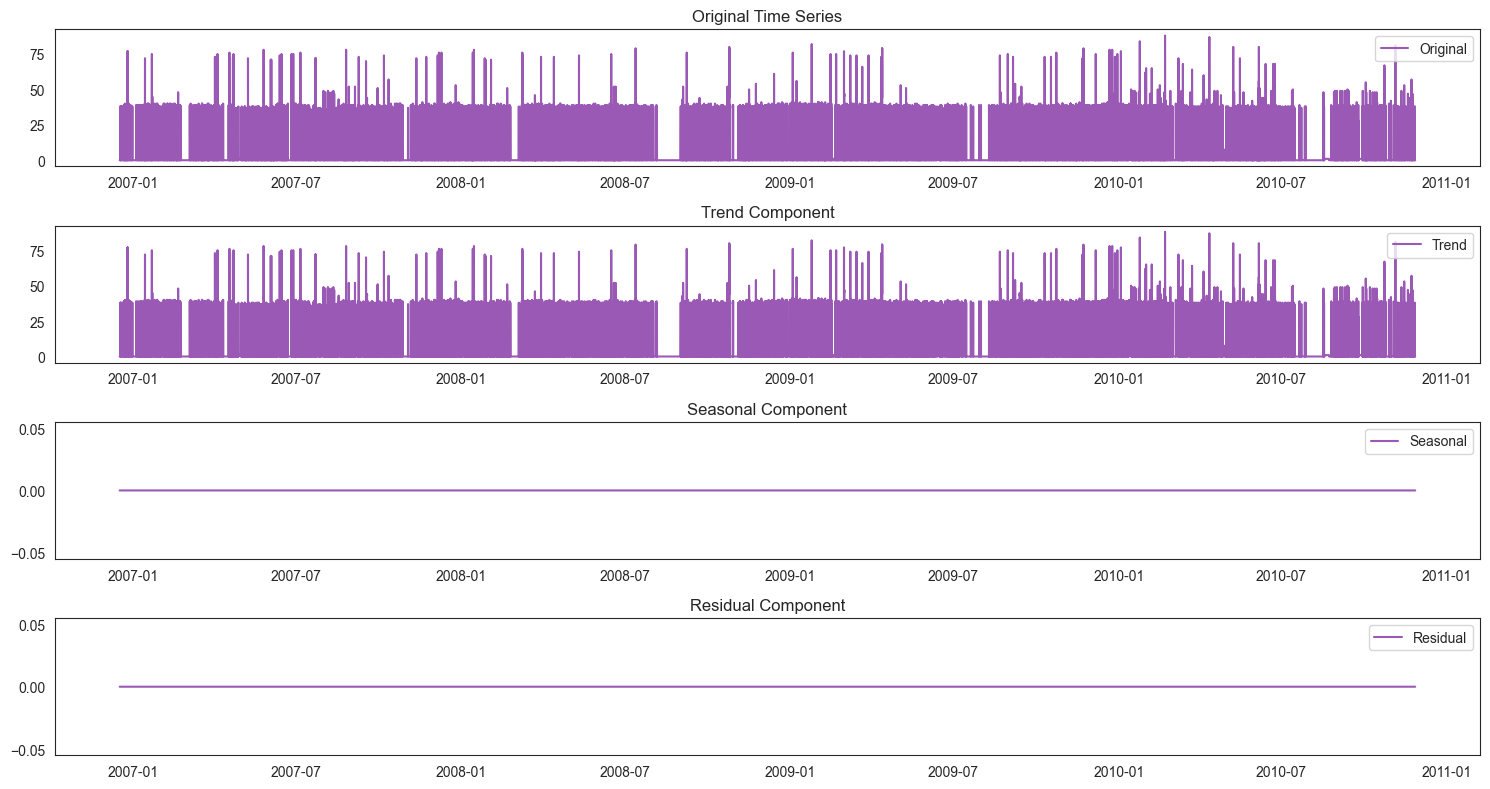

In [23]:
decompose_time_series(df=energy_data, column_name='Sub_metering_1')

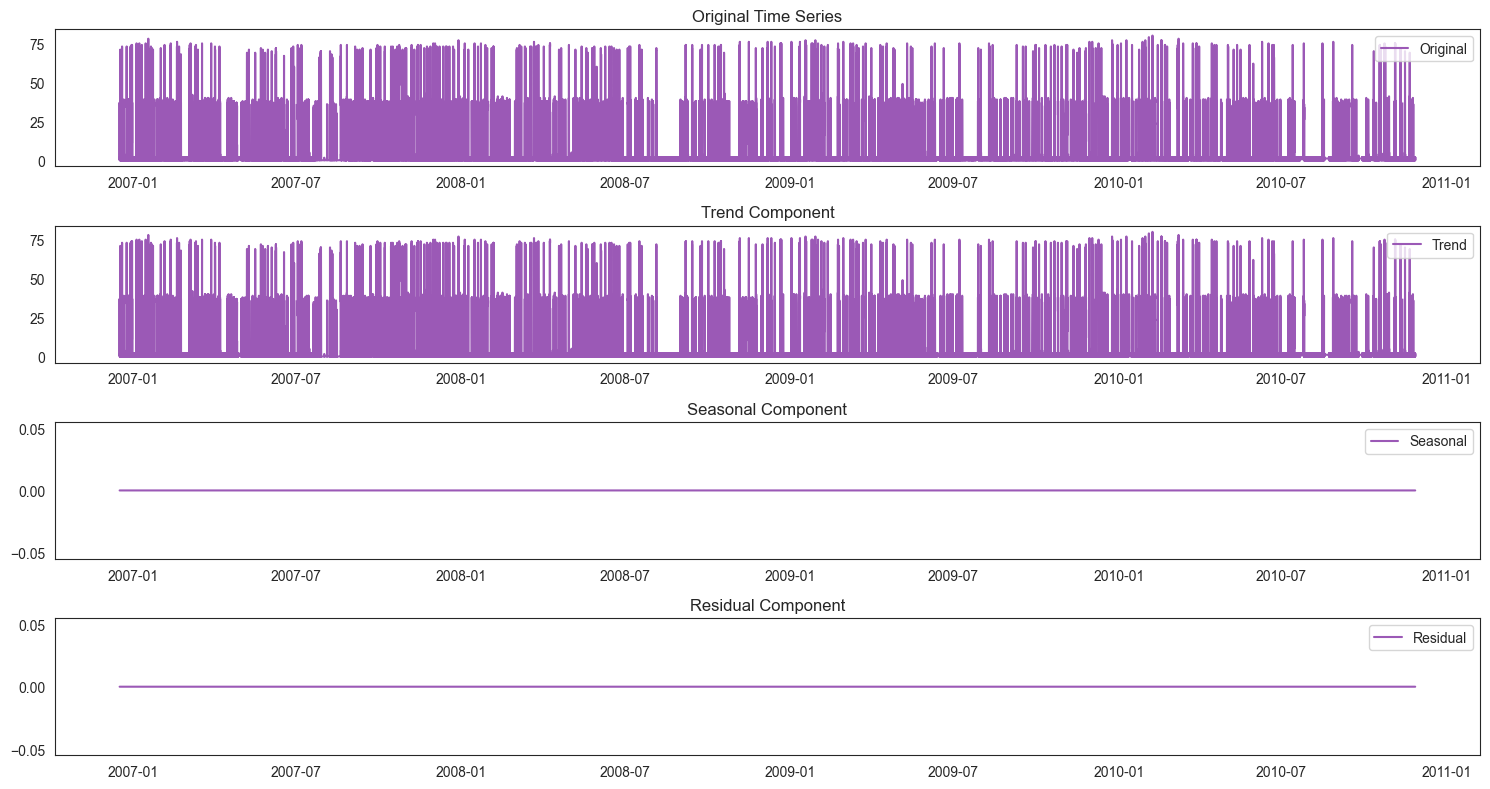

In [24]:
decompose_time_series(df=energy_data, column_name='Sub_metering_2')

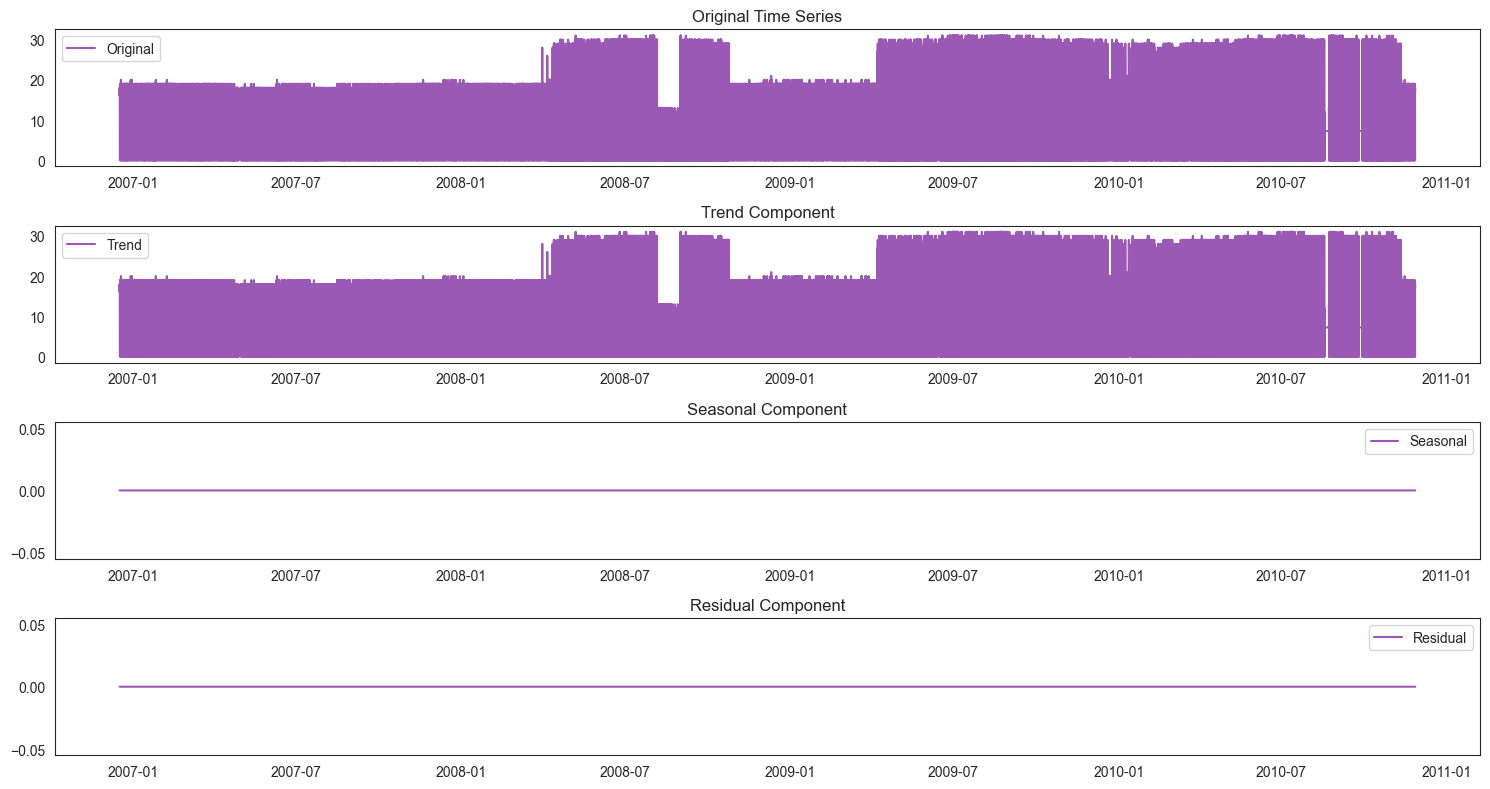

In [25]:
decompose_time_series(df=energy_data, column_name='Sub_metering_3')

#### Analysis

From the decomposition graph, there is no evident trend or seasonality. But from the above analysis, we can observe there is seasonlity to some extent from the spikes

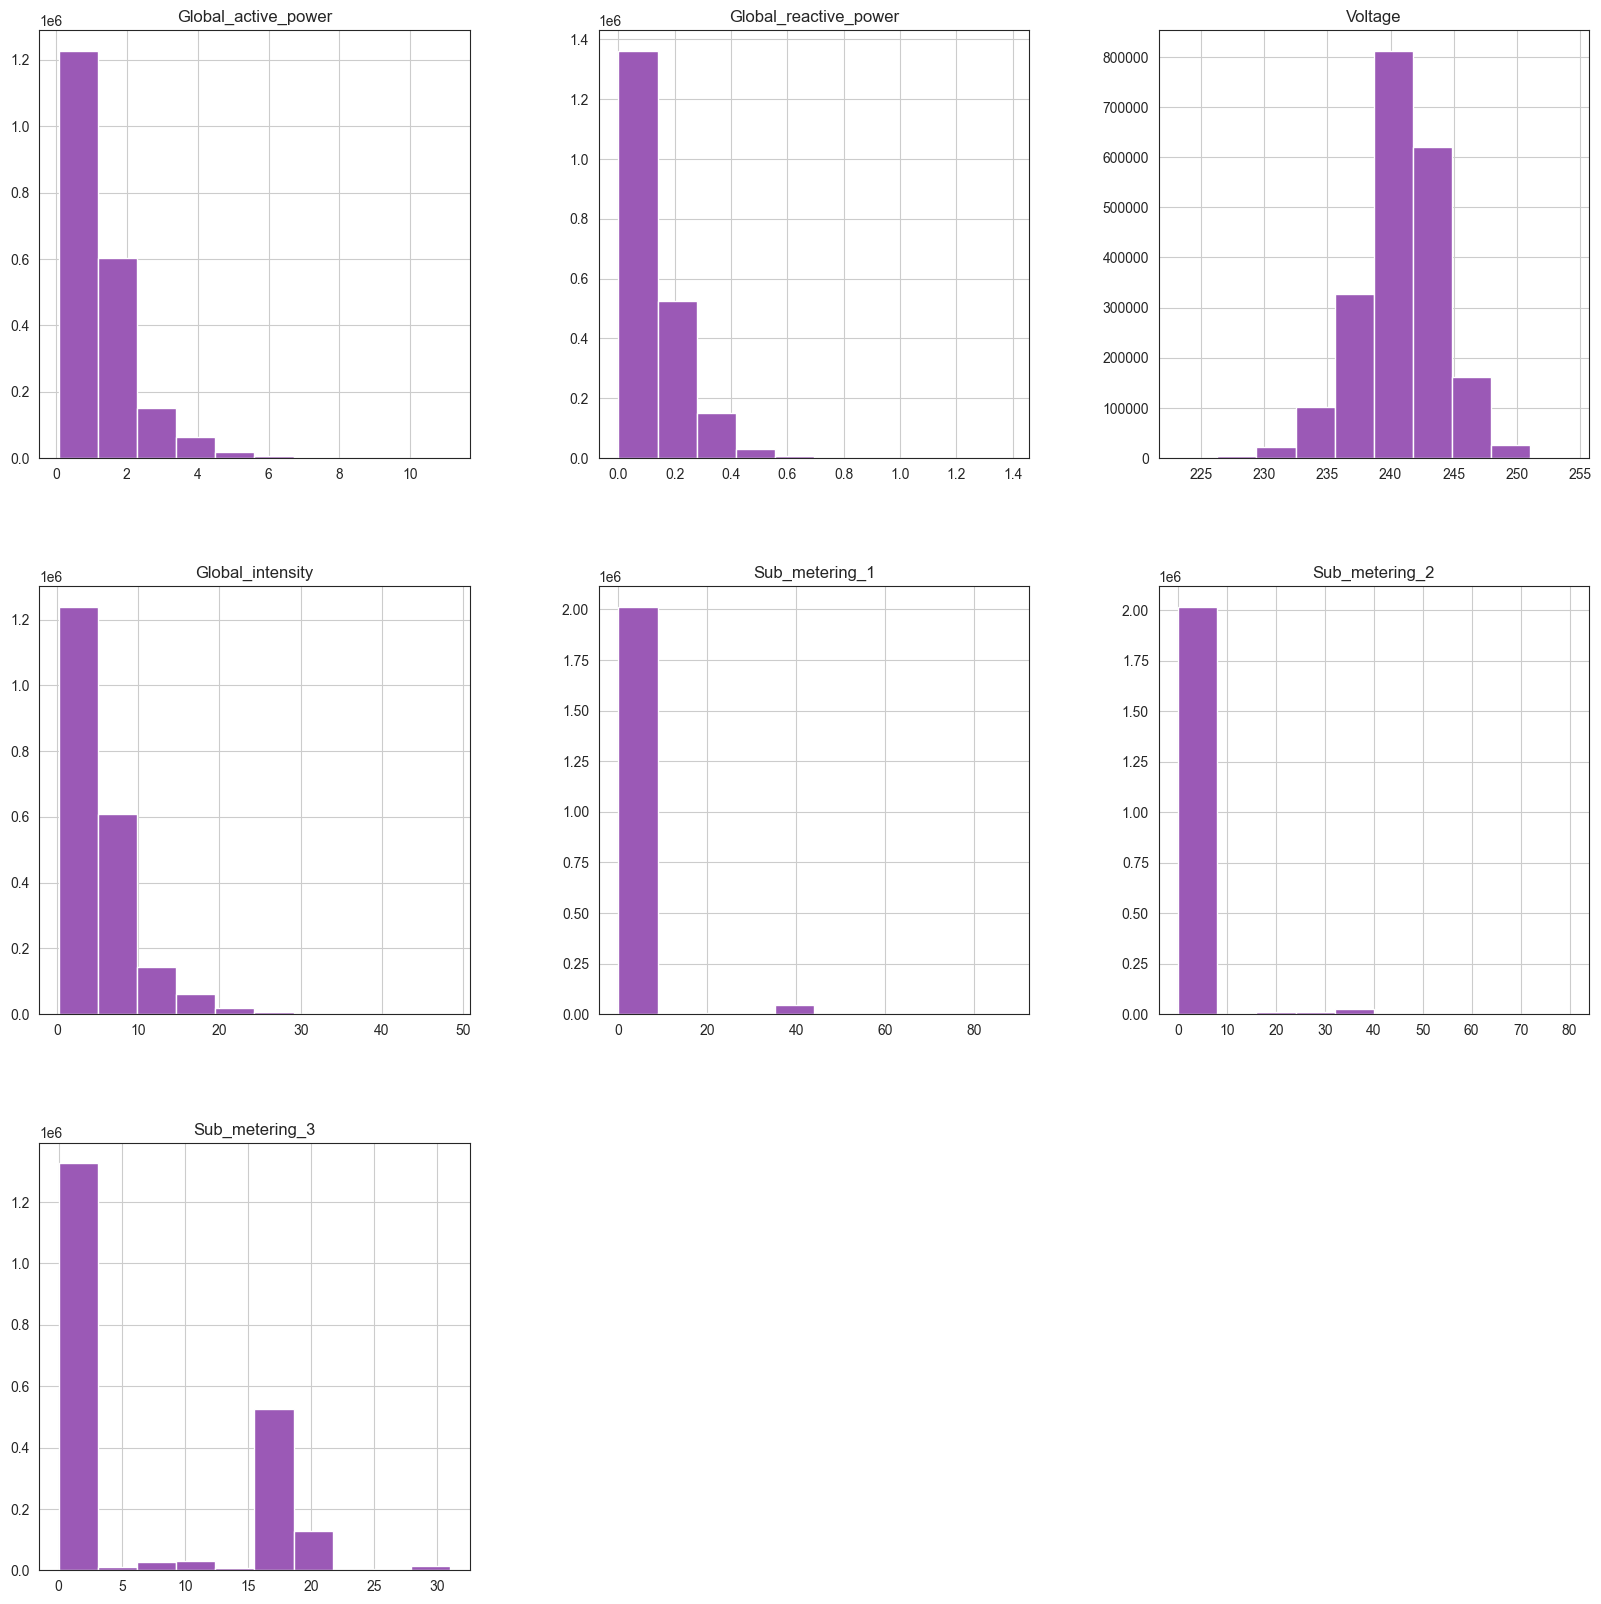

In [26]:
# Plotting Histogram for the original data
energy_data.hist(figsize=(20,20))
plt.show()

**Analysis** 
- Voltage is somewhat normally distributed
- Rest of the variables are mostly left skewed

### Data ReSampling, Data Distribution and Correlation Analsysis

In [27]:
def resampling_visualizations(data, resample_level, title):
    """Resample the data based on input and create trend, distribution and correlation plots"""
    assert resample_level in ('H', 'D', 'M'), f"Allowed resample levels are hourly, daily and monthly"

    
    # resample the data 
    resample_df = data.resample(resample_level).mean()
    print(f"Size of the Resampled Data : {resample_df.shape[0]}")

    # Plot the resampled data 
    resample_df.plot(subplots=True, figsize=(30,8), title=title)

    # Plot the data distributions
    resample_df.hist(figsize=(20,20))

    # Plot the correlation matrix
    plt.figure(figsize=(10,10))
    sns.heatmap(resample_df.corr(),annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

Size of the Resampled Data : 34589


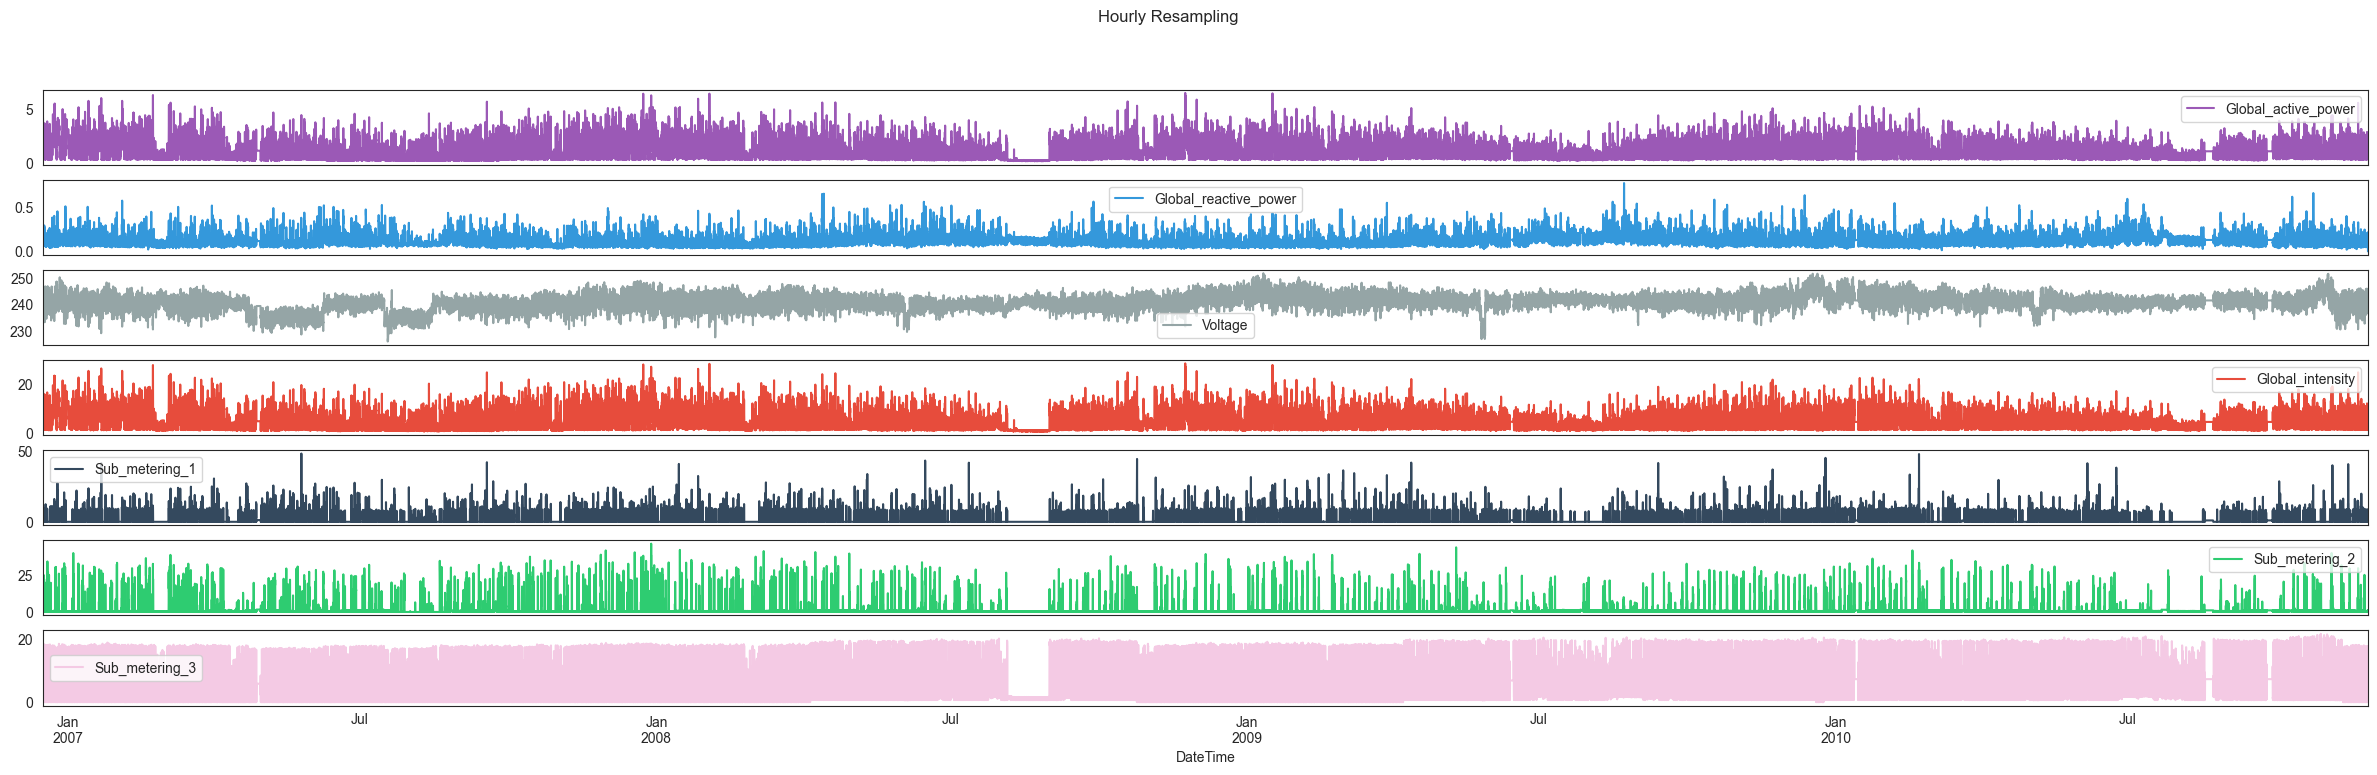

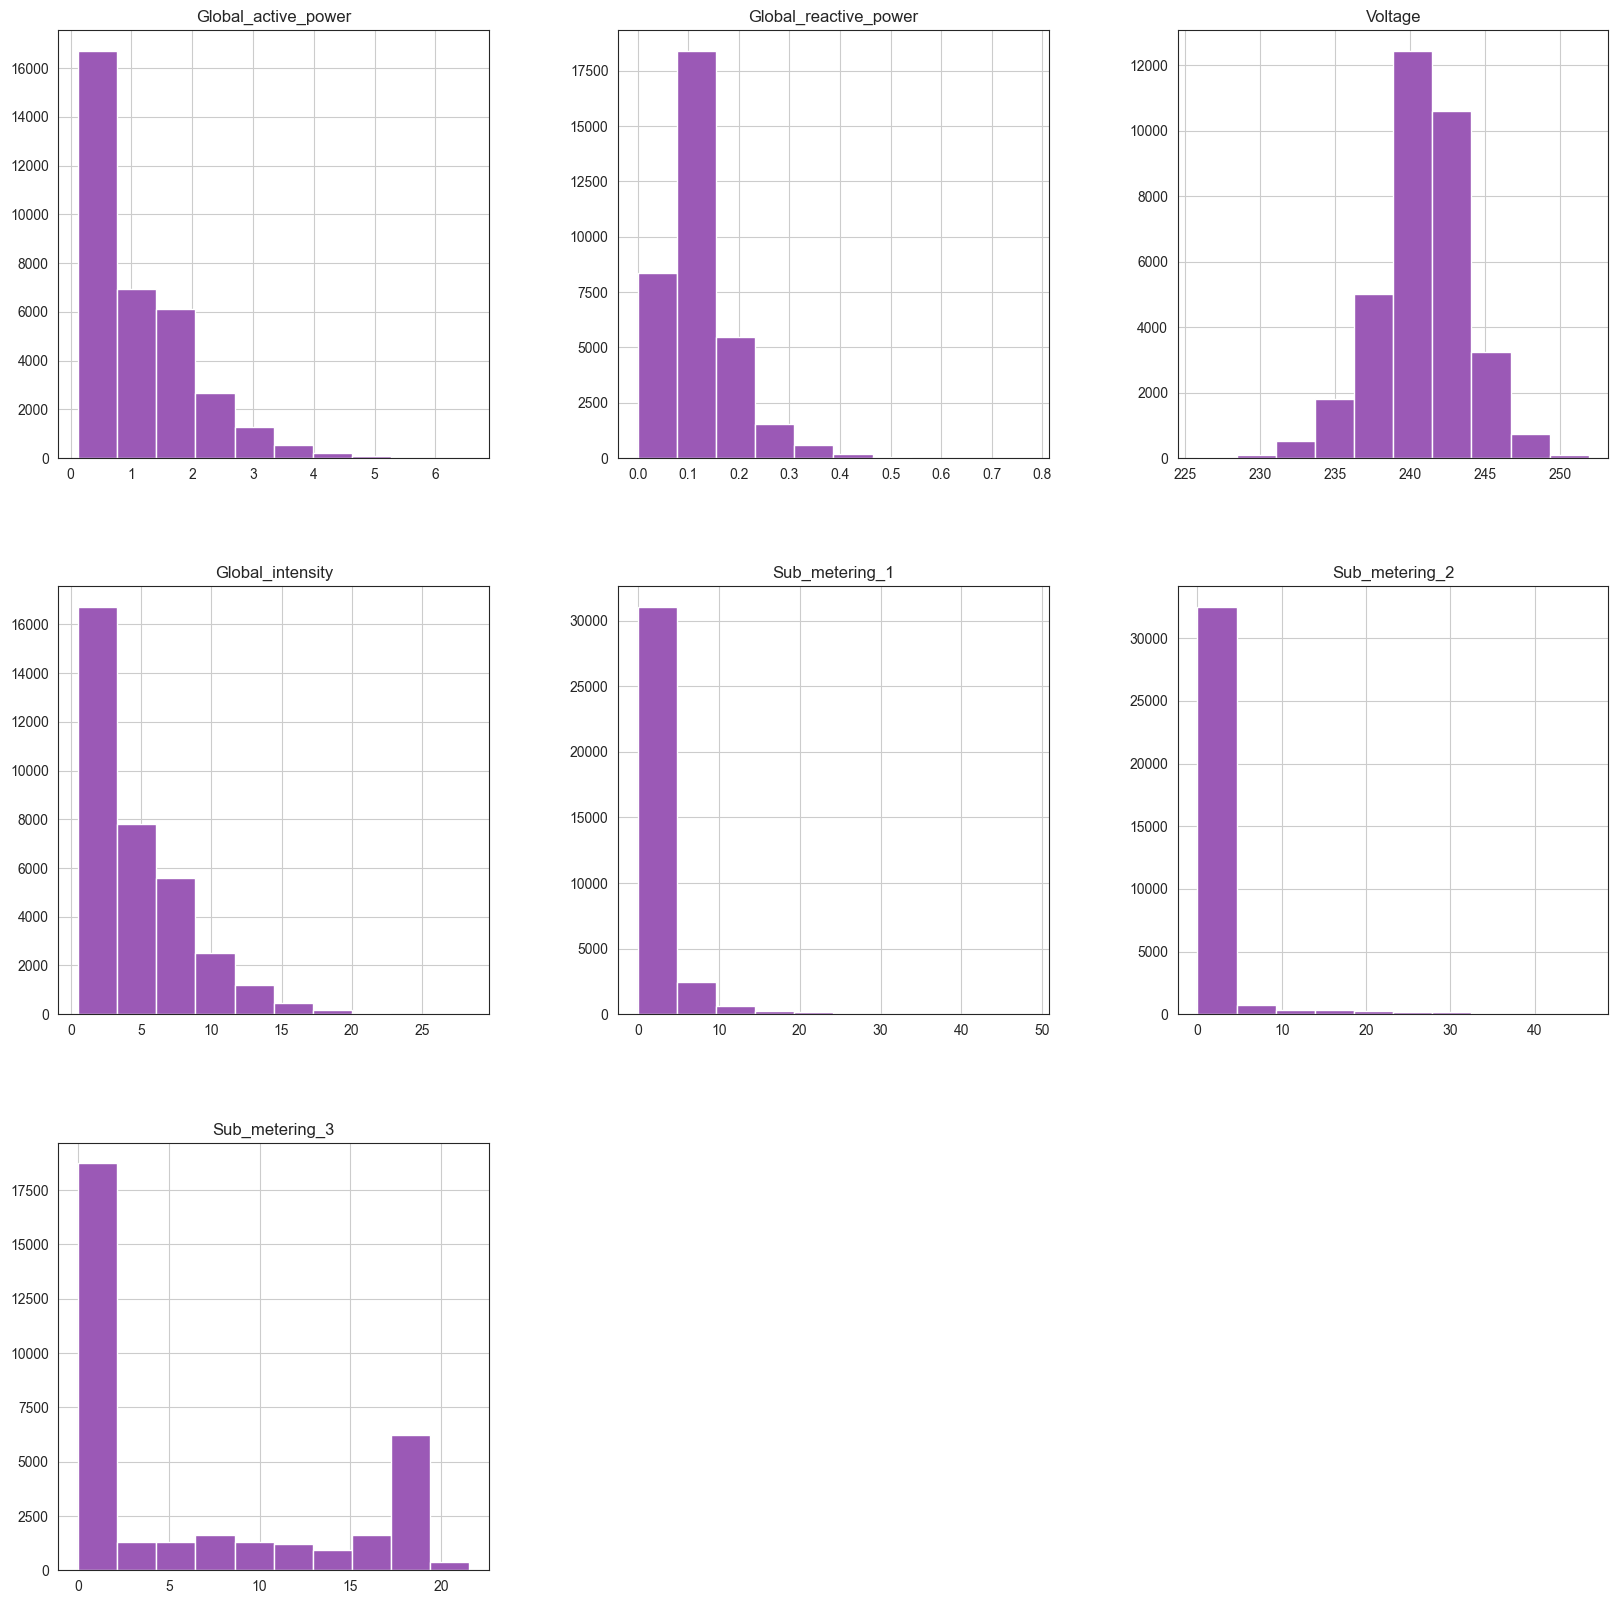

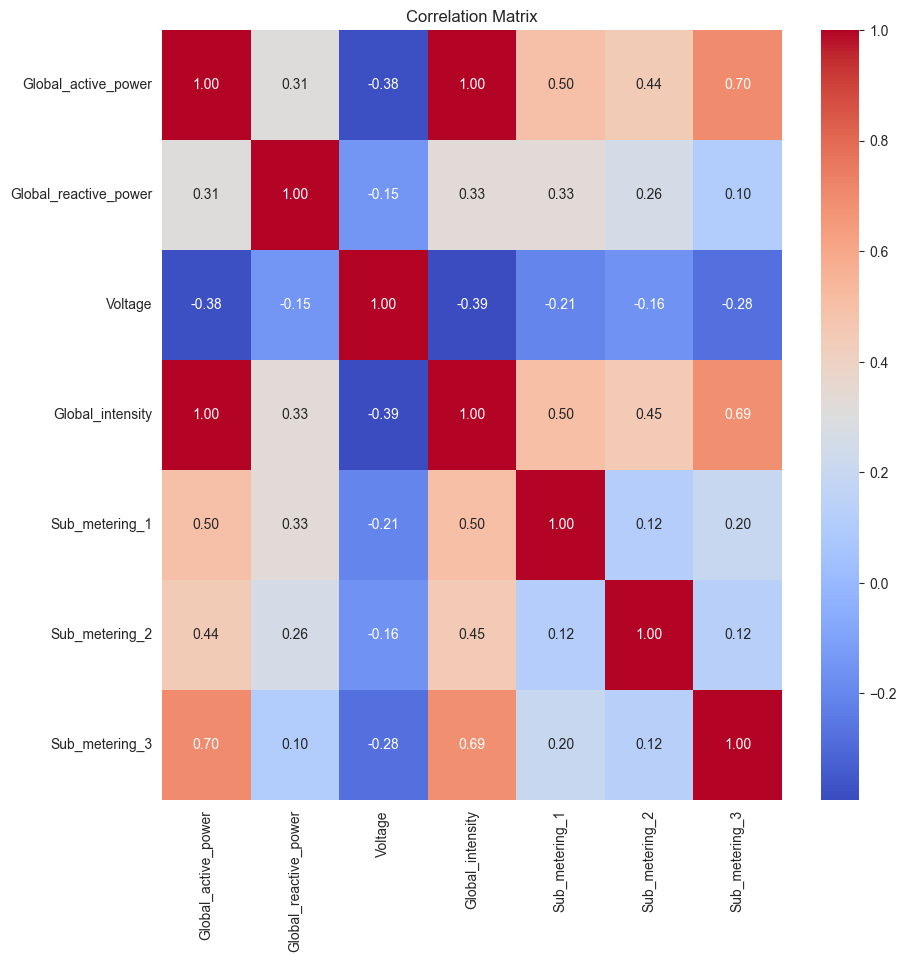

In [28]:
resampling_visualizations(data=energy_data, resample_level='H', title='Hourly Resampling')

**Analysis of Hourly Sampling**

- The data has smoothend out a bit but more or less looks like the original data
- The trends and seasonlity are not lost during the resampling
- However most of the variables are still left skewed, which is not desirable as we need data with constant mean, normal data is desriable
- Global Active Power has become perfectlt correlated with the Global Intensity. It is desirable to drop any of them as otherwise they will cause multi-collinearity


Size of the Resampled Data : 1442


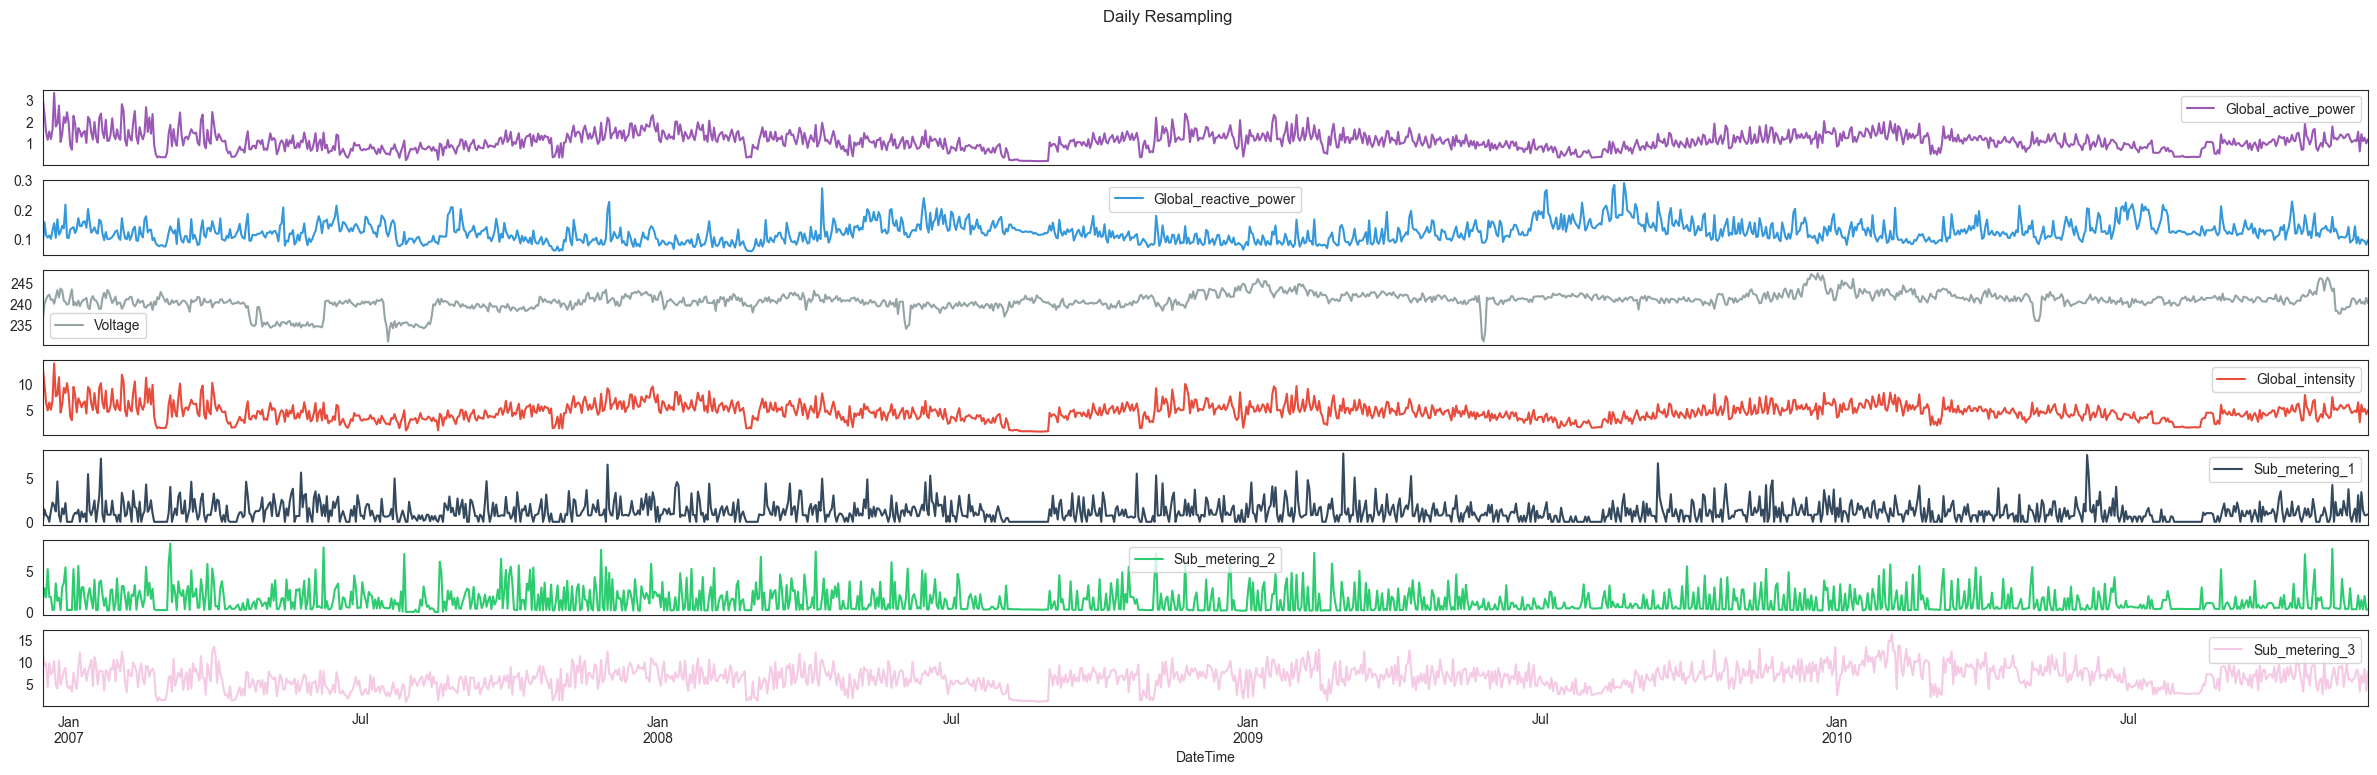

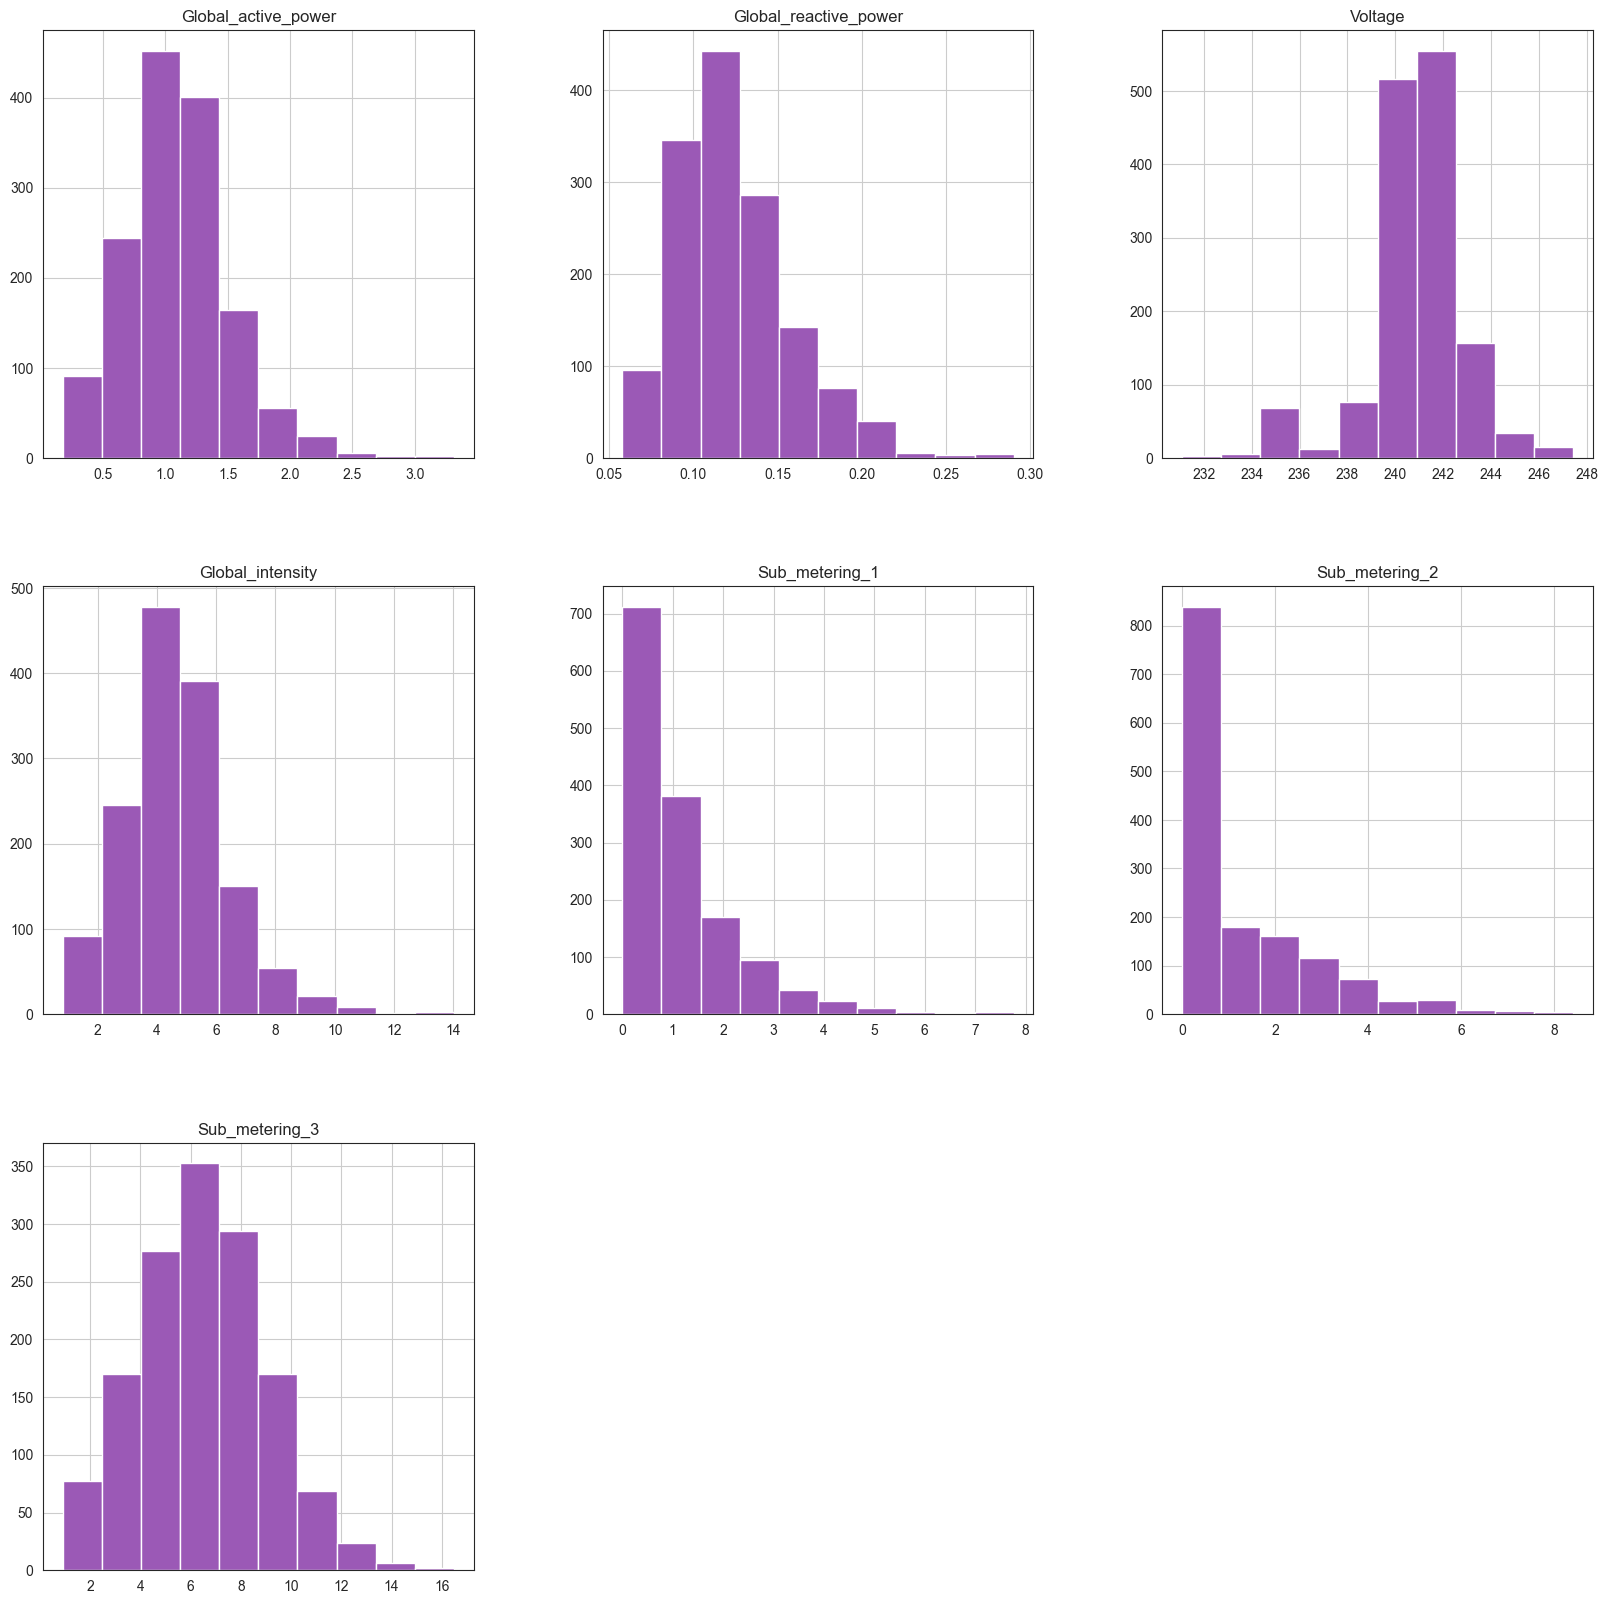

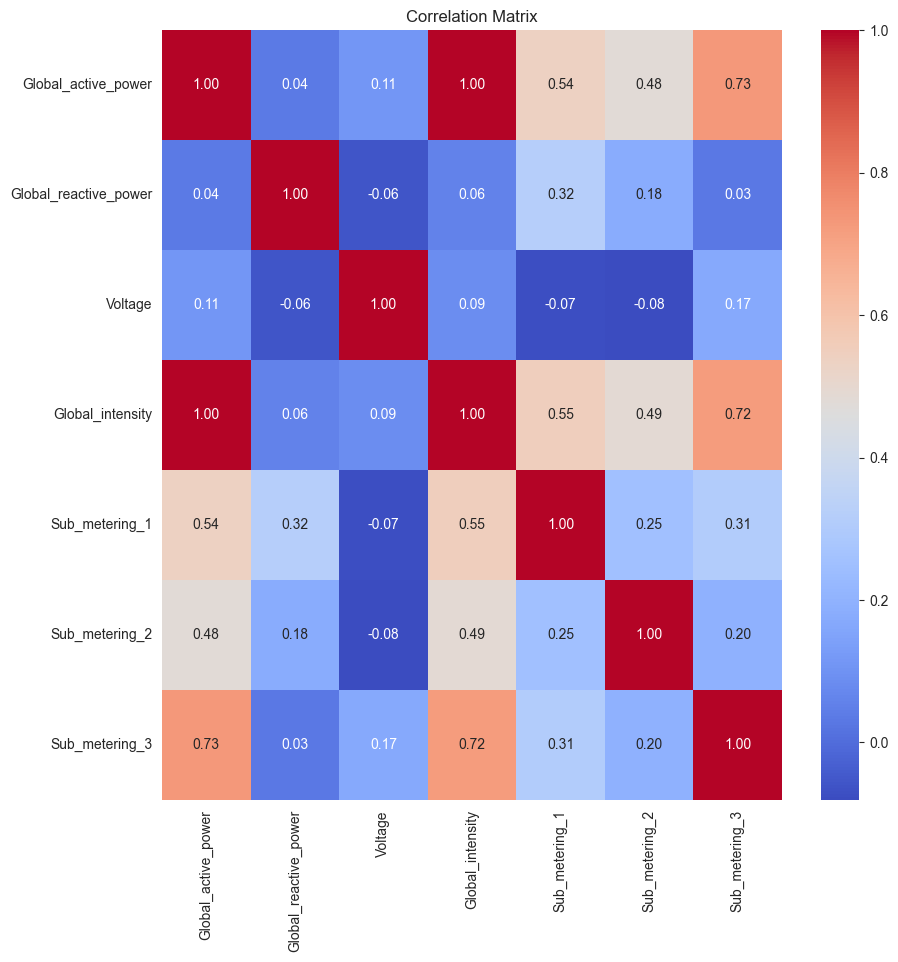

In [29]:
resampling_visualizations(data=energy_data, resample_level='D', title='Daily Resampling')

**Analysis of Hourly Sampling**

- The data has smoothend quite a bit here. But at the same time, it is retaining the trends and seasonality as discussed in the earlier analysis.
- Other than sub_metering_1 and sub_metering_2, the rest of the variables have attained more or less normal distribution. This is desirable
- Here also, global_active_power has perfect correlation with the global intensity

Size of the Resampled Data : 48


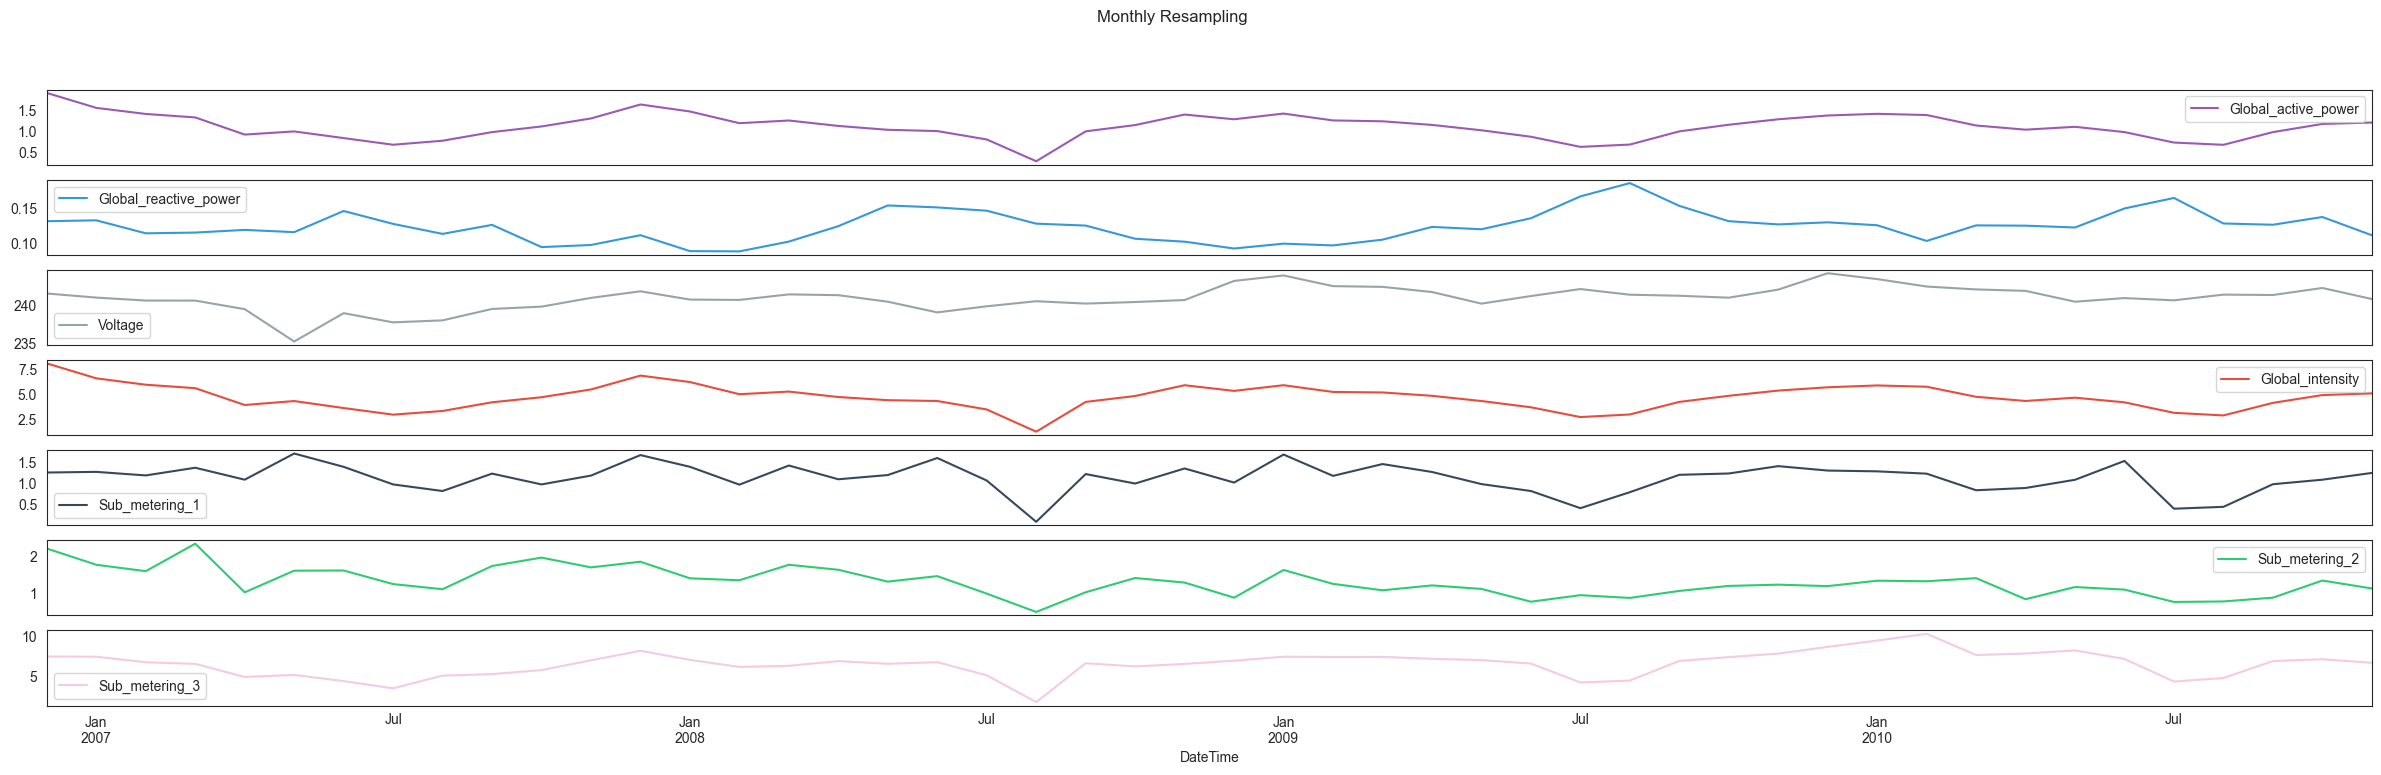

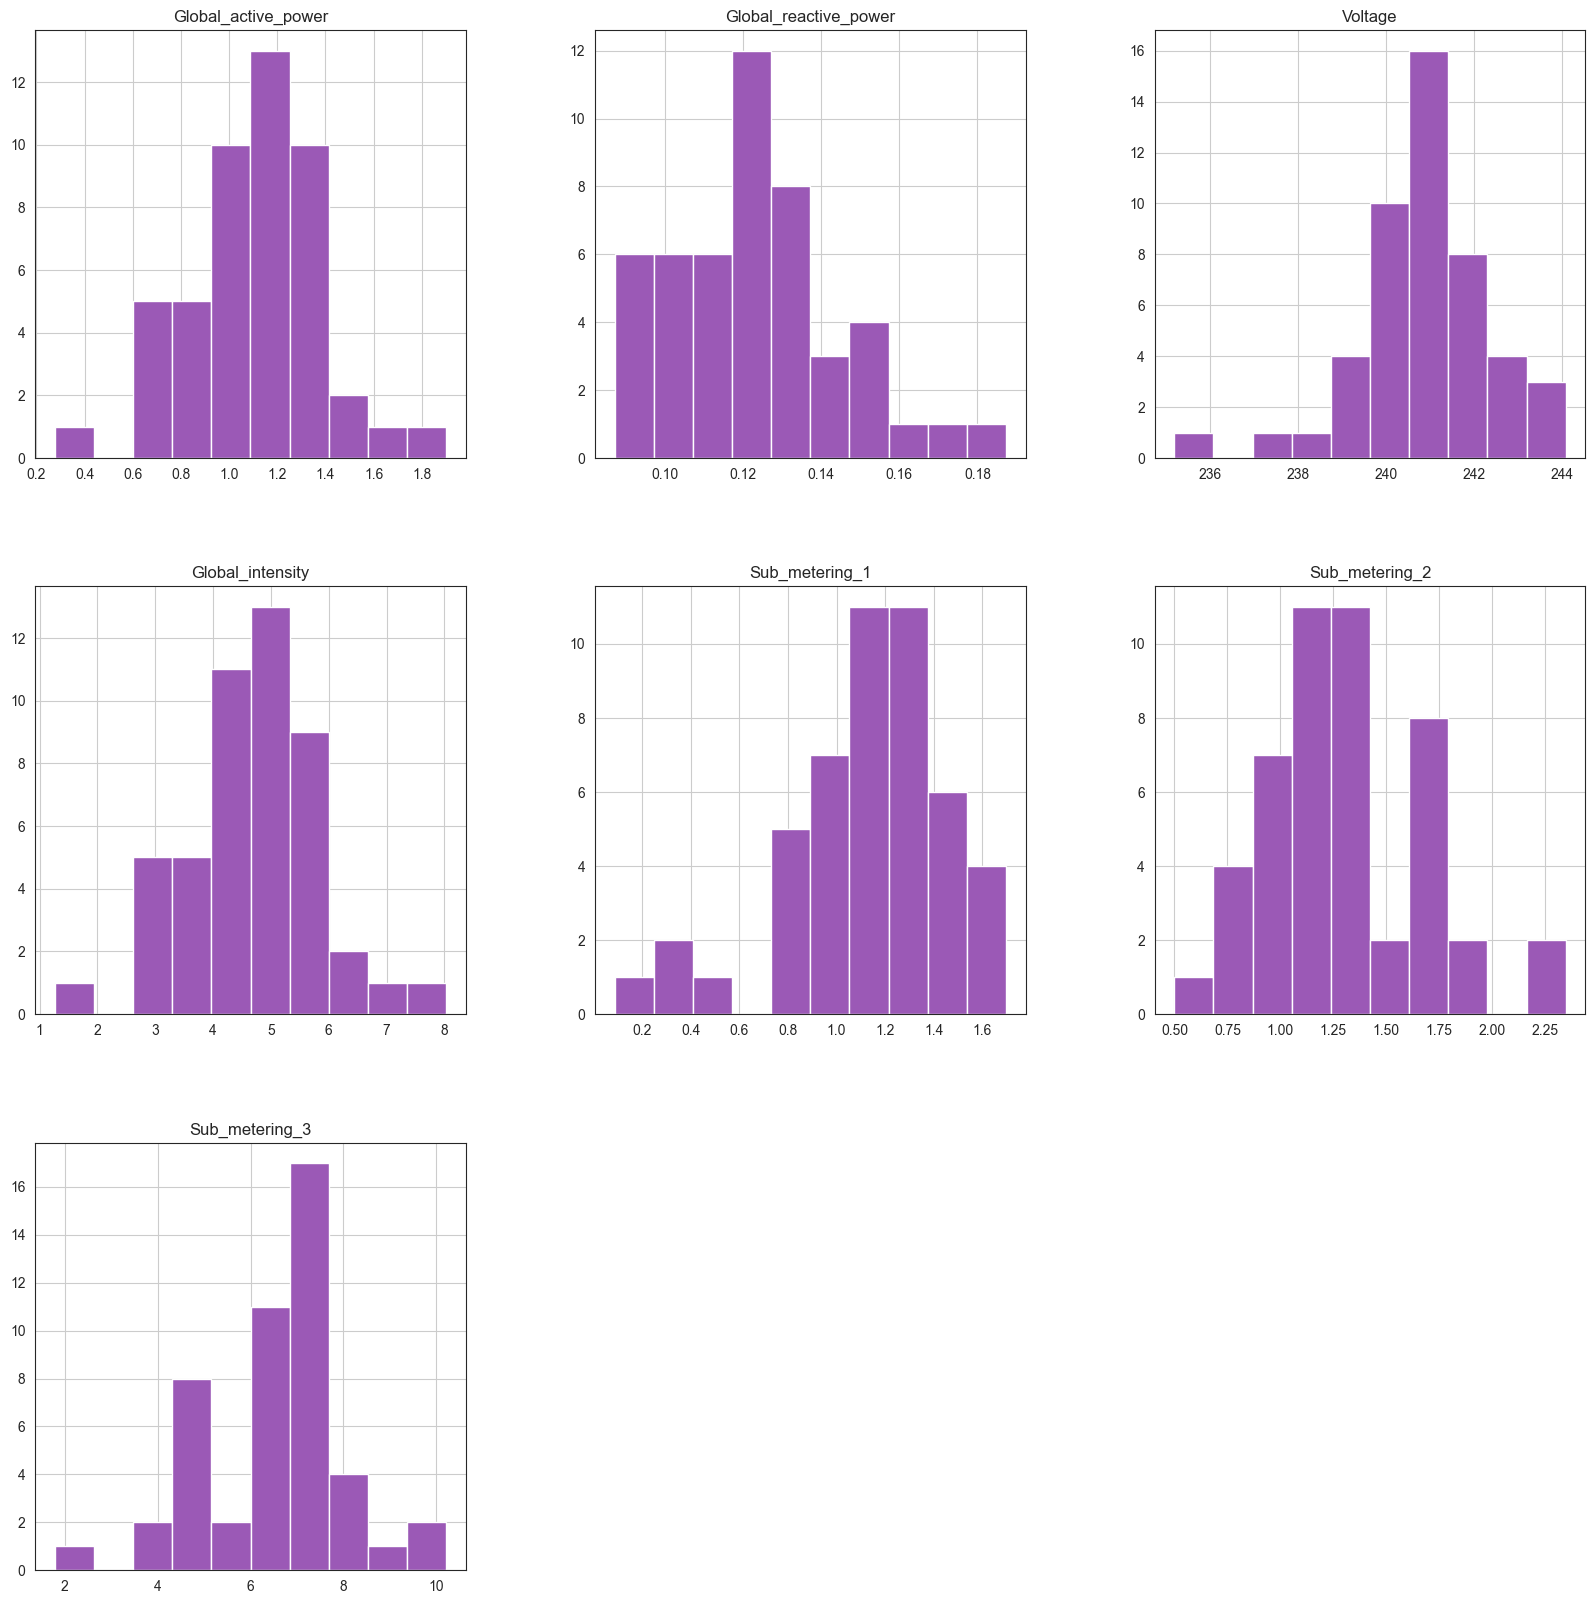

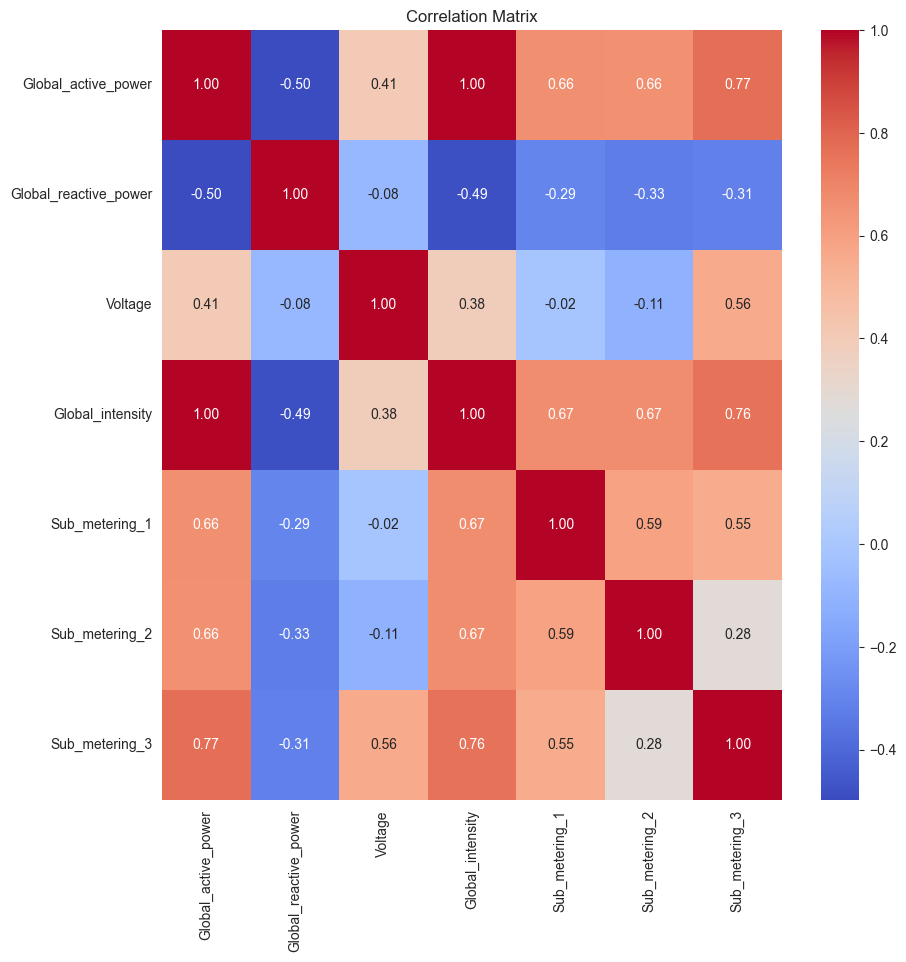

In [30]:
resampling_visualizations(data=energy_data, resample_level='M', title='Monthly Resampling')

**Analysis of Monthly resampling**

- The data has smoothened a lot here. The seasonal patterns have disappeared here which is not very desirable. Also data has become excessively small (48 in size only)
- All the variables have attained almost normal distribution
- Global Active power is perfectly correlated with global intensity here also

#### Conclusions from Resampling

- The daily level sampling looks best here. It has smoothened the data as well as retained the trends and seasonality patterns. Most of the variables are normal here.
- We can drop global_active_power since it is perfectly correlated with the global_intensity

In [35]:
df_final = energy_data.resample('D').mean()
print(f"Final Data Size : {df_final.shape[0]}")

df_final.head()

Final Data Size : 1442


Global_active_power  Global_reactive_power     Voltage  \
DateTime                                                             
2006-12-16             3.053475               0.088187  236.243763   
2006-12-17             2.354486               0.156949  240.087028   
2006-12-18             1.530435               0.112356  241.231694   
2006-12-19             1.157079               0.104821  241.999313   
2006-12-20             1.545658               0.111804  242.308062   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
DateTime                                                                      
2006-12-16         13.082828        0.000000        1.378788       12.439394  
2006-12-17          9.999028        1.411806        2.907639        9.264583  
2006-12-18          6.421667        0.738194        1.820139        9.734722  
2006-12-19          4.926389        0.582639        5.279167        4.303472  
2006-12-20          6.467361        0.000000        1.838889        9.765972

### Stationary Check 

In [32]:
def check_stationarity(df, col_name, alpha=0.05):
    print(f"Checking Stationarity:",col_name)
    result = adfuller(df[col_name])
    p_value = result[1]

    if p_value <= alpha:
        print(f"P-Val : {p_value}, {col_name} is stationary")

    print()

In [33]:
alpha = 0.05
for col in df_final.columns:
    check_stationarity(df = df_final, col_name=col, alpha=alpha)

Checking Stationarity: Global_reactive_power
P-Val : 0.0027132029723624666, Global_reactive_power is stationary

Checking Stationarity: Voltage
P-Val : 0.0005807060129088727, Voltage is stationary

Checking Stationarity: Global_intensity
P-Val : 0.0028474439864733755, Global_intensity is stationary

Checking Stationarity: Sub_metering_1
P-Val : 2.611756932664965e-06, Sub_metering_1 is stationary

Checking Stationarity: Sub_metering_2
P-Val : 1.6488384074449015e-05, Sub_metering_2 is stationary

Checking Stationarity: Sub_metering_3
P-Val : 0.0010908314682838915, Sub_metering_3 is stationary



**Stationarity Test Analysis**
From the above test, p-values of all the variables are less than 5 %, so we can conclude that entire time series data is stationary.
We can proceed to the model building step now